### Preparation of the data

In [30]:
%pip install seaborn wordcloud pyyaml matplotlib


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
from utils import get_configs, get_duplicates, load_data, display_unique_values, merge_datasets
from params import REFERENCE_DATE, DEFAULT_JOB_TYPE, DEFAULT_EMAIL_PROVIDER, MISSING_FLOAT_DEFAULT

In [32]:
config = get_configs('configs.yaml')

In [33]:
base_path = config['data_paths']['base_path']
file_paths = config['data_paths']

#### Data Types

In [34]:
df_customers = load_data(os.path.join(base_path, file_paths['customers']), dtype={
    'customer_id': str,
    'address_id': str,
    'birthdate': str,
    'gender': str,
    'job_type': str,
    'email_provider': str,
    'flag_phone_provided': float,
    'flag_privacy': bool
}, parse_dates=['birthdate'])

df_products = load_data(os.path.join(base_path, file_paths['products']), dtype={
    'product_id': str,
    'product_class': str
})

df_labelled_reviews = load_data(os.path.join(base_path, file_paths['labelled_reviews']), dtype={
    'labelled_reviews_index': str,
    'review_text': str,
    'sentiment_label': str
})

df_orders = load_data(os.path.join(base_path, file_paths['orders']), dtype={
    'order_id': str,
    'customer_id': str,
    'store_id': str,
    'product_id': str,
    'direction': int,
    'gross_price': float,
    'price_reduction': float
}, parse_dates=['purchase_datetime'])

df_addresses = load_data(os.path.join(base_path, file_paths['addresses']), dtype={
    'address_id': str,
    'postal_code': str,
    'district': str,
    'region': str
})

df_customer_reviews = load_data(os.path.join(base_path, file_paths['customer_reviews']), dtype={
    'review_id': str,
    'customer_id': str,
    'review_text': str
})

df_customer_accounts = load_data(os.path.join(base_path, file_paths['customer_accounts']), dtype={
    'customer_id': str,
    'account_id': str,
    'favorite_store': str,
    'loyalty_type': str,
    'loyalty_status': bool
}, parse_dates=['activation_date'])

# Verify data types
print("Data Types for Each DataFrame:")
for df_name, df in [('Customers', df_customers), ('Products', df_products), ('Orders', df_orders), ('Addresses', df_addresses), ('Customer Reviews', df_customer_reviews), ('Customer Accounts', df_customer_accounts)]:
    print(f"\n{df_name} DataFrame:")
    print(df.dtypes)

Data Types for Each DataFrame:

Customers DataFrame:
customer_id                    object
address_id                     object
birthdate              datetime64[ns]
gender                         object
job_type                       object
email_provider                 object
flag_phone_provided           float64
flag_privacy                     bool
dtype: object

Products DataFrame:
product_id       object
product_class    object
dtype: object

Orders DataFrame:
order_id                     object
customer_id                  object
store_id                     object
product_id                   object
direction                     int64
gross_price                 float64
price_reduction             float64
purchase_datetime    datetime64[ns]
dtype: object

Addresses DataFrame:
address_id     object
postal_code    object
district       object
region         object
dtype: object

Customer Reviews DataFrame:
review_id      object
customer_id    object
review_text    object
dtype:

#### Missing Values

In [35]:
# Customers

# Filling missing values for job_type with 'Unknown', email_provider with 'unknown@example.com', and 'False' if NaN in flag_phone
df_customers['job_type'].fillna(DEFAULT_JOB_TYPE, inplace=True)
df_customers['email_provider'].fillna(DEFAULT_EMAIL_PROVIDER, inplace=True)
df_customers['flag_phone_provided'].fillna(MISSING_FLOAT_DEFAULT, inplace=True)
# Phone provided from float to bool
df_customers['flag_phone_provided'] = df_customers['flag_phone_provided'].apply(lambda x: x == 1.0)

# Already check and no NaT in 'birthdate', 'purchase_datetime', 'activation_date'

#### Duplicates

In [36]:
df_orders.drop_duplicates(inplace=True)
print(f"Total rows after removing exact duplicates in Orders: {len(df_orders)}")

df_addresses.drop_duplicates(inplace=True)
print(f"Total rows after removing exact duplicates in Addresses: {len(df_addresses)}")

Total rows after removing exact duplicates in Orders: 917000
Total rows after removing exact duplicates in Addresses: 157765


In [37]:
customer_data, order_data, merged_data = merge_datasets(df_customers, df_products, df_orders, df_addresses, df_customer_accounts)
merged_data.head()

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,product_class,address_id,...,flag_phone_provided,flag_privacy,postal_code,district,region,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.40,0.0,2022-10-04 18:28:51,6,21,...,True,True,21050,VA,LOMBARDIA,512658,49,standard,1,2022-09-08
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,8.30,0.0,2022-10-04 18:28:51,6,21,...,True,True,21050,VA,LOMBARDIA,512658,49,standard,1,2022-09-08
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,1.99,0.0,2022-10-04 18:28:51,6,21,...,True,True,21050,VA,LOMBARDIA,512658,49,standard,1,2022-09-08
3,8fe4346b53d0c781b275a614175804de,23,49,33795776,1,5.10,0.0,2022-10-04 18:28:51,6,21,...,True,True,21050,VA,LOMBARDIA,512658,49,standard,1,2022-09-08
4,8fe4346b53d0c781b275a614175804de,23,49,36235381,1,76.05,0.0,2022-10-04 18:28:51,6,21,...,True,True,21050,VA,LOMBARDIA,512658,49,standard,1,2022-09-08


In [38]:
merged_data.columns

Index(['order_id', 'customer_id', 'store_id', 'product_id', 'direction',
       'gross_price', 'price_reduction', 'purchase_datetime', 'product_class',
       'address_id', 'birthdate', 'gender', 'job_type', 'email_provider',
       'flag_phone_provided', 'flag_privacy', 'postal_code', 'district',
       'region', 'account_id', 'favorite_store', 'loyalty_type',
       'loyatlty_status', 'activation_date'],
      dtype='object')

In [39]:
merged_data['birthdate']

0        1978-08-14
1        1978-08-14
2        1978-08-14
3        1978-08-14
4        1978-08-14
            ...    
919824   1979-09-28
919825   1964-01-29
919826   1964-01-29
919827   1979-05-18
919828   1988-02-24
Name: birthdate, Length: 917000, dtype: datetime64[ns]

#### Customer Demographics


Customer Demographics Analysis
count    140946.000000
mean         46.851972
std           8.750514
min          21.000000
25%          41.000000
50%          45.000000
75%          49.000000
max          95.000000
Name: age, dtype: float64


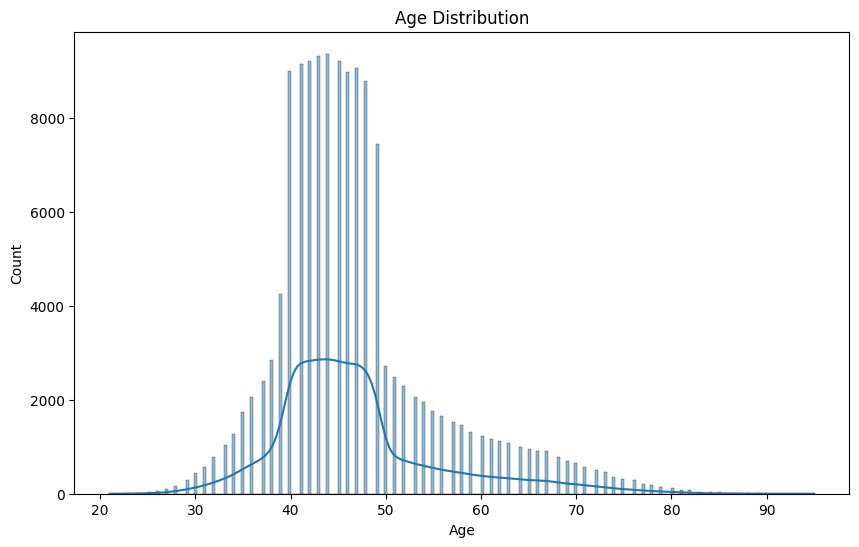

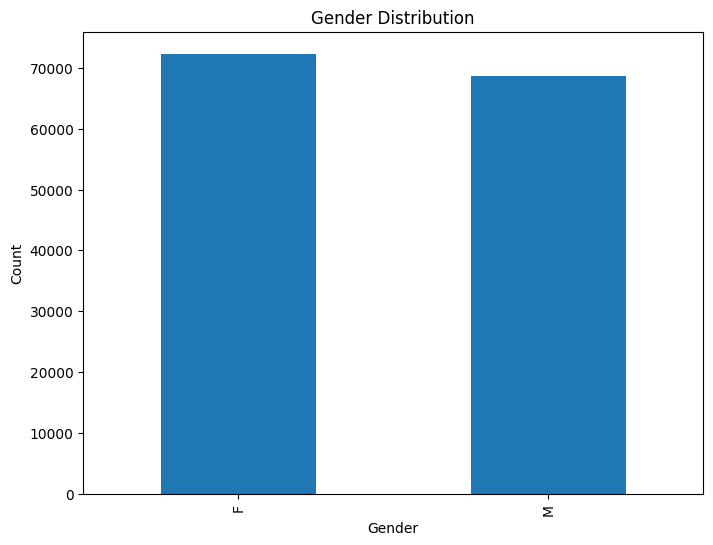

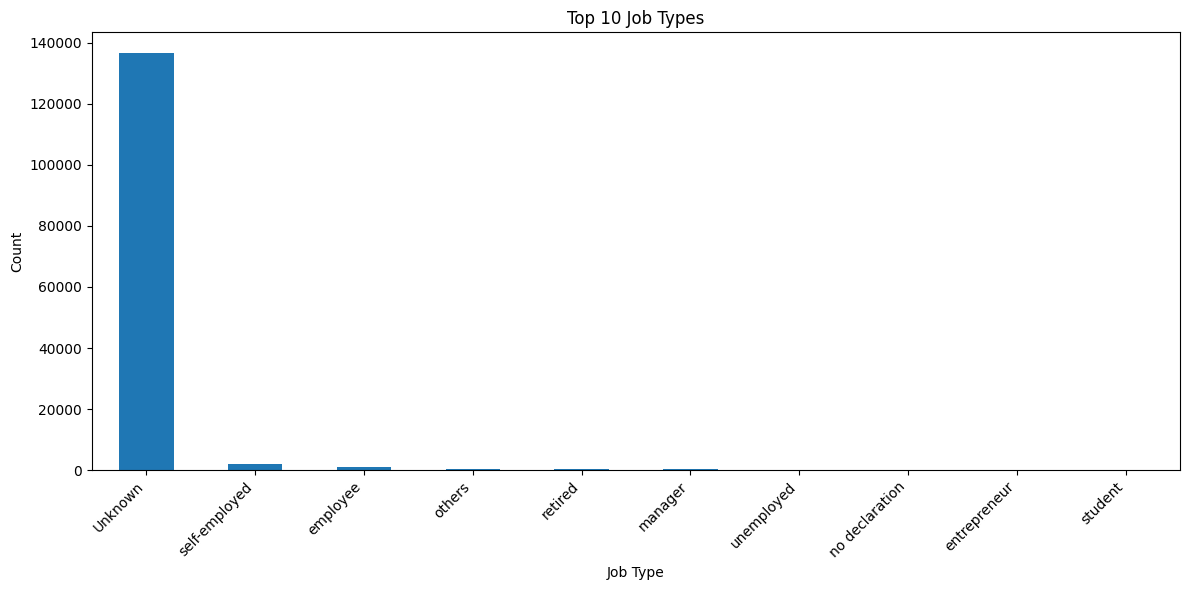

In [40]:
def analyze_customer_demographics(merged_data):
    print("\nCustomer Demographics Analysis")
    
    # Handle missing values and drop rows with NaT birthdate
    merged_data['birthdate'] = pd.to_datetime(merged_data['birthdate'], errors='coerce')
    merged_data = merged_data.dropna(subset=['birthdate'])
    merged_data['gender'] = merged_data['gender'].fillna('Unknown')
    merged_data['job_type'] = merged_data['job_type'].fillna('Unknown')

    # Calculate age
    current_date = pd.Timestamp.now()
    merged_data['age'] = pd.to_numeric((REFERENCE_DATE - merged_data['birthdate']).dt.days, downcast='integer').div(365).round().astype(int)
    
    print(merged_data['age'].describe())
    
    # Age distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_data['age'], kde=True)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.show()

    # Gender distribution
    gender_counts = merged_data['gender'].value_counts()
    plt.figure(figsize=(8, 6))
    gender_counts.plot(kind='bar')
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()

    # Job type distribution (top 10)
    job_counts = merged_data['job_type'].value_counts().nlargest(10)
    plt.figure(figsize=(12, 6))
    job_counts.plot(kind='bar')
    plt.title('Top 10 Job Types')
    plt.xlabel('Job Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

analyze_customer_demographics(df_customers)

#### Order Patterns


Order Patterns Analysis


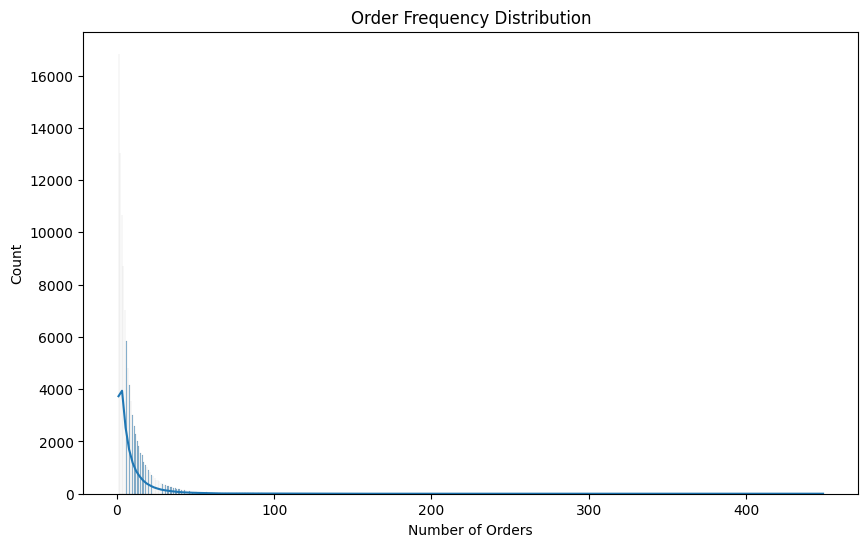

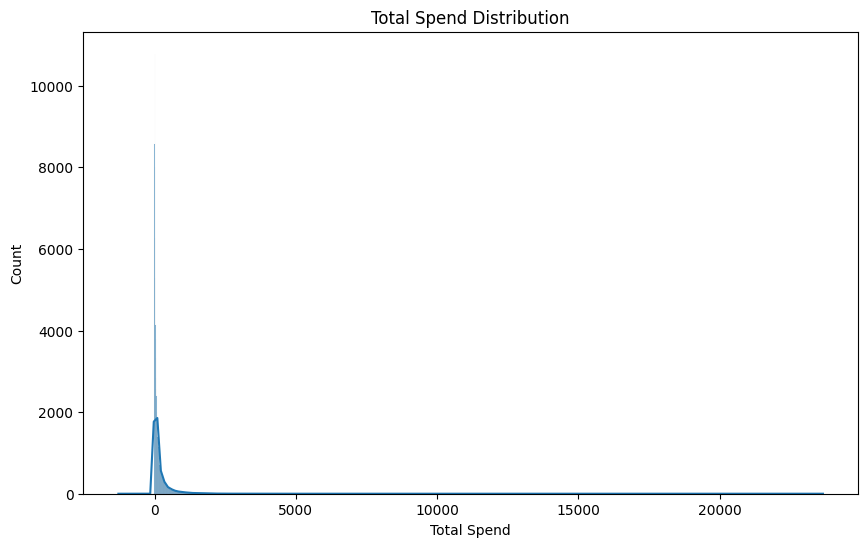

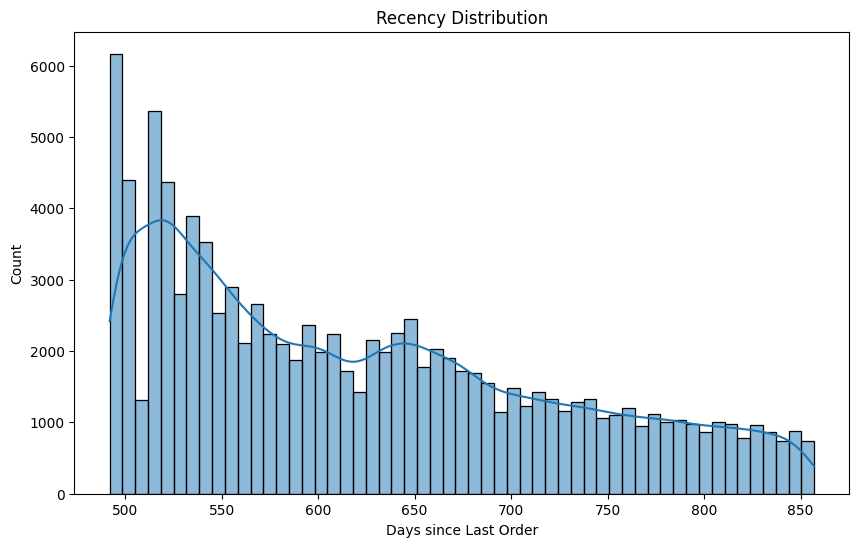

In [41]:
def analyze_order_patterns(order_data):
    print("\nOrder Patterns Analysis")
    
    # Frequency: number of orders per customer
    order_frequency = order_data.groupby('customer_id').size().reset_index(name='order_count')
    plt.figure(figsize=(10, 6))
    sns.histplot(order_frequency['order_count'], kde=True)
    plt.title('Order Frequency Distribution')
    plt.xlabel('Number of Orders')
    plt.show()

    # Monetary Value: total spend per customer
    monetary_value = order_data.groupby('customer_id')['gross_price'].sum().reset_index(name='total_spend')
    plt.figure(figsize=(10, 6))
    sns.histplot(monetary_value['total_spend'], kde=True)
    plt.title('Total Spend Distribution')
    plt.xlabel('Total Spend')
    plt.show()

    # Recency: days since last order
    last_order_date = order_data.groupby('customer_id')['purchase_datetime'].max().reset_index(name='last_order_date')
    last_order_date['recency'] = (REFERENCE_DATE - last_order_date['last_order_date']).dt.days
    plt.figure(figsize=(10, 6))
    sns.histplot(last_order_date['recency'], kde=True)
    plt.title('Recency Distribution')
    plt.xlabel('Days since Last Order')
    plt.show()

analyze_order_patterns(order_data)

#### Product Popularity


Product Popularity Analysis


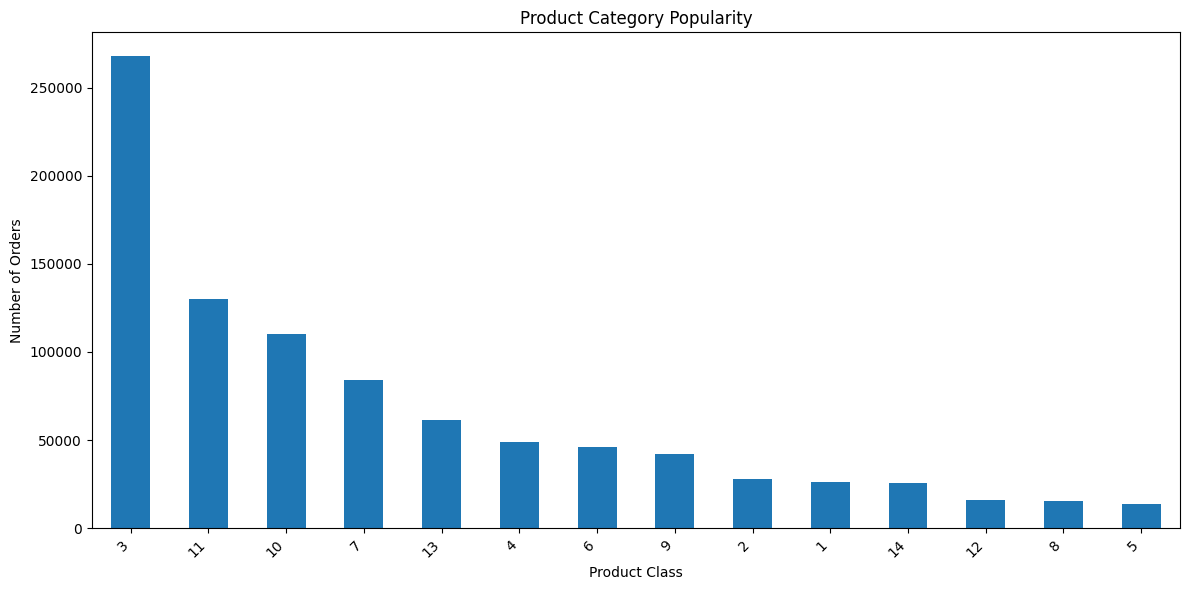

In [42]:
def analyze_product_popularity(merged_data):
    print("\nProduct Popularity Analysis")
    
    # Product category popularity
    category_popularity = merged_data.groupby('product_class').size().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    category_popularity.plot(kind='bar')
    plt.title('Product Category Popularity')
    plt.xlabel('Product Class')
    plt.ylabel('Number of Orders')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

analyze_product_popularity(merged_data)


#### Customer Reviews Analysis


Customer Reviews Analysis


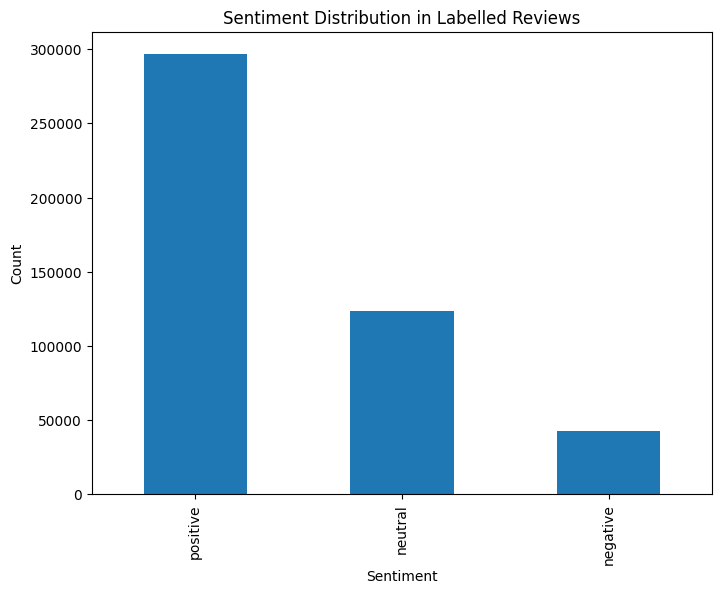

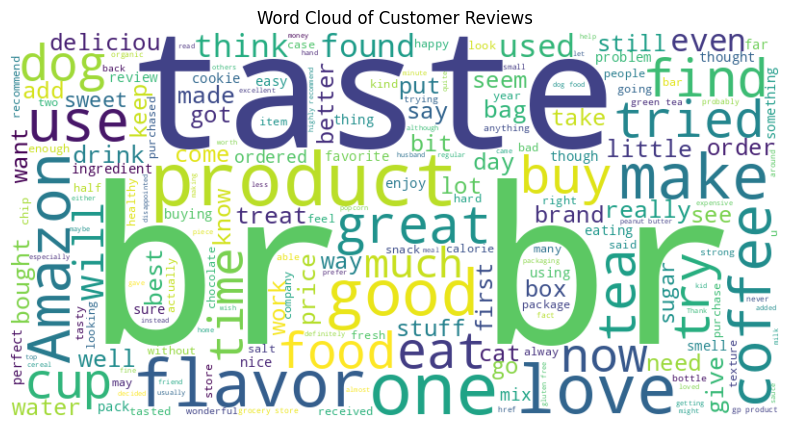

In [43]:
def analyze_customer_reviews(df_customer_reviews, df_labelled_reviews):
    print("\nCustomer Reviews Analysis")
    
    # Sentiment distribution in labelled reviews
    sentiment_counts = df_labelled_reviews['sentiment_label'].value_counts()
    plt.figure(figsize=(8, 6))
    sentiment_counts.plot(kind='bar')
    plt.title('Sentiment Distribution in Labelled Reviews')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

    # Word cloud of review text
    from wordcloud import WordCloud
    all_reviews = ' '.join(df_customer_reviews['review_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Customer Reviews')
    plt.show()

analyze_customer_reviews(df_customer_reviews, df_labelled_reviews)  

# Experimental (we can remove this later)

In [44]:
# df_customers = load_data(os.path.join(base_path, file_paths['customers']))
# df_products = load_data(os.path.join(base_path, file_paths['products']))
# df_labelled_reviews = load_data(os.path.join(base_path, file_paths['labelled_reviews']))
# df_orders = load_data(os.path.join(base_path, file_paths['orders']))
# df_addresses = load_data(os.path.join(base_path, file_paths['addresses']))
# df_customer_reviews = load_data(os.path.join(base_path, file_paths['customer_reviews']))
# df_customer_accounts = load_data(os.path.join(base_path, file_paths['customer_accounts']))


# print("The first 3 entry for Each DataFrame:")
# for df_name, df in [('Customers', df_customers), ('Products', df_products), ('Orders', df_orders), ('Addresses', df_addresses), ('Customer Reviews', df_customer_reviews), ('Customer Accounts', df_customer_accounts)]:
#     print(f"\n{df_name} DataFrame:")
#     print(df.head(3))

[LOG] Outliers detected in column 'gross_price'


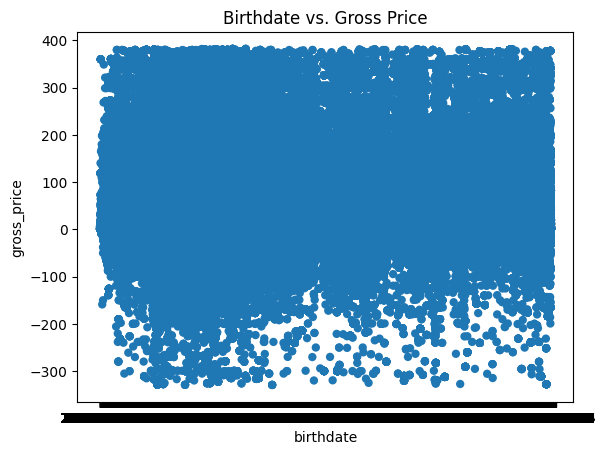

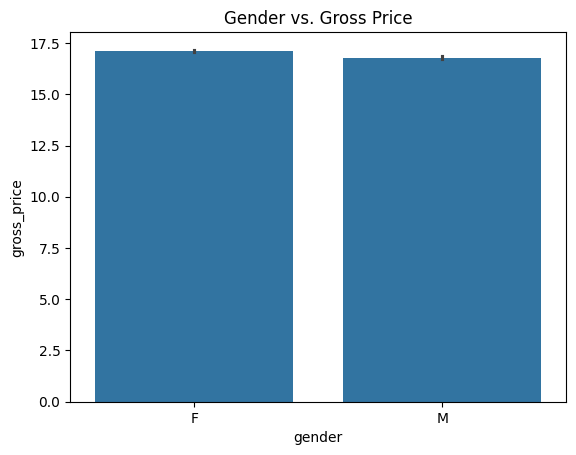

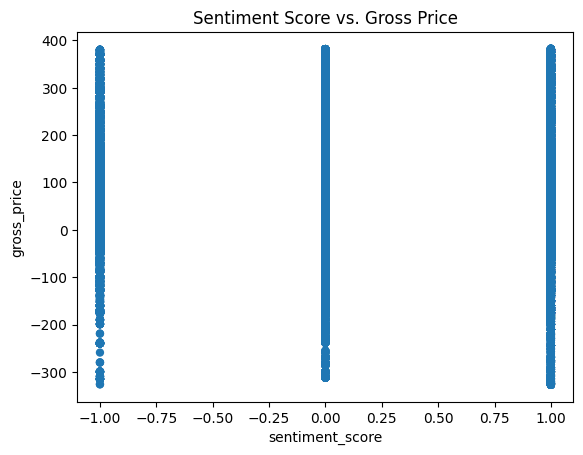

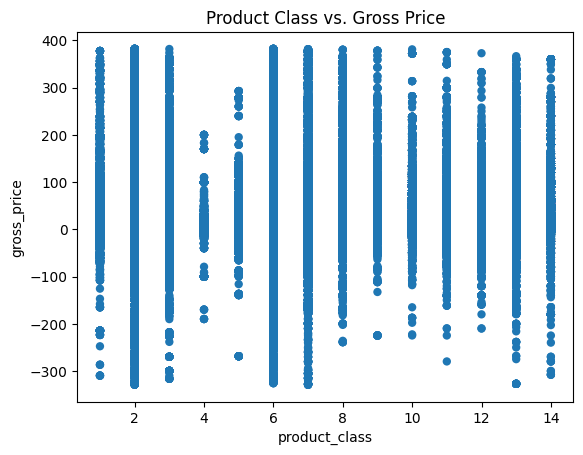

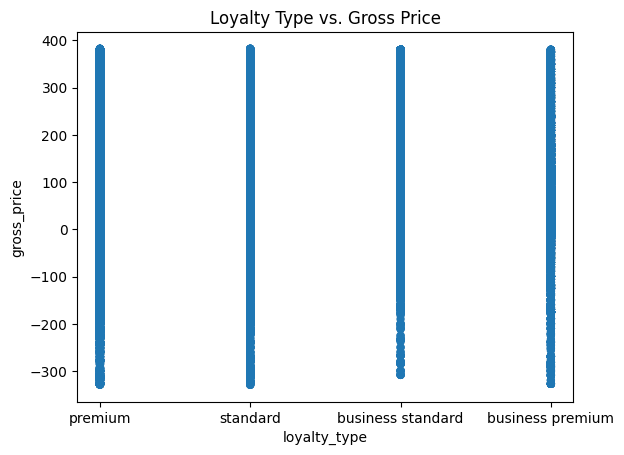

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Function to detect and handle outliers
def detect_and_handle_outliers(df, columns):
    for col in columns:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            z_scores = np.abs(zscore(df[col].dropna()))
            # log when outliers are detected and replaced
            if np.sum(z_scores > 3) > 0:
                print(f"[LOG] Outliers detected in column '{col}'")
            outlier_indices = np.where(z_scores > 3)[0]
            df.loc[df.index[outlier_indices], col] = df[col].median()
    return df

# Function to assign review sentiment score
def assign_review_sentiment_score(review_data):
    sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
    review_data['sentiment_score'] = review_data['sentiment_label'].map(sentiment_map)
    return review_data

# Function to join the datasets with adjusted logic
def join_datasets_corrected(df_customers, df_products, df_labelled_reviews, df_orders, df_addresses, df_customer_reviews, df_customer_accounts):
    # Join Customers, Orders, and Addresses
    customer_order_address = df_customers.merge(df_orders, on='customer_id', how='left') \
                                         .merge(df_addresses, on='address_id', how='left')

    # Join Products
    customer_order_address_products = customer_order_address.merge(df_products, on='product_id', how='left')

    # Join Customer Reviews
    merged_data = customer_order_address_products.merge(df_customer_reviews, on='customer_id', how='left')

    # Join Customer Accounts
    merged_data = merged_data.merge(df_customer_accounts, on='customer_id', how='left')

    # Add sentiment_score from df_labelled_reviews based on review_text match
    merged_data = merged_data.merge(df_labelled_reviews[['review_text', 'sentiment_score']], on='review_text', how='left')
    
    return merged_data

# Explore insights from the joined dataset
def explore_joined_data(merged_data):
    # Analyze the relationship between customer demographics and order patterns
    sns.scatterplot(x='birthdate', y='gross_price', data=merged_data, edgecolor='none')
    plt.title('Birthdate vs. Gross Price')
    plt.show()

    sns.barplot(x='gender', y='gross_price', data=merged_data)
    plt.title('Gender vs. Gross Price')
    plt.show()

    # Explore the relationship between product characteristics and customer reviews
    sns.scatterplot(x='sentiment_score', y='gross_price', data=merged_data, edgecolor='none')
    plt.title('Sentiment Score vs. Gross Price')
    plt.show()

    sns.scatterplot(x='product_class', y='gross_price', data=merged_data, edgecolor='none')
    plt.title('Product Class vs. Gross Price')
    plt.show()

    # Analyze the impact of customer loyalty on order patterns
    sns.scatterplot(x='loyalty_type', y='gross_price', data=merged_data, edgecolor='none')
    plt.title('Loyalty Type vs. Gross Price')
    plt.show()

# Main function to run the data exploration and outlier detection with corrected dataset joining
def explore_data_quality_and_insights_corrected():
    # Create synthetic datasets based on the provided structure

    # df_customers = pd.DataFrame({
    #     'customer_id': ['891057', '655484', '514958'],
    #     'address_id': ['863914', '639856', '494806'],
    #     'birthdate': pd.to_datetime(['2001-10-22', '2001-04-30', '2001-01-01']),
    #     'gender': ['F', 'M', 'M'],
    #     'job_type': [np.nan, np.nan, np.nan],
    #     'email_provider': ['yahoo.it', 'yahoo.it', 'libero.it'],
    #     'flag_phone_provided': [1.0, 1.0, 1.0],
    #     'flag_privacy': [True, False, True]
    # })

    # df_products = pd.DataFrame({
    #     'product_id': ['35996051', '35980371', '31276196'],
    #     'product_class': ['9', '14', '4']
    # })

    # df_labelled_reviews = pd.DataFrame({
    #     'labelled_reviews_index': ['1', '2', '3'],
    #     'review_text': ['Great product!', 'Not bad', 'Worst product ever'],
    #     'sentiment_label': ['positive', 'neutral', 'negative']
    # })

    # df_orders = pd.DataFrame({
    #     'order_id': ['8fe4346b53d0c781b275a614175804de', '8fe4346b53d0c781b275a614175804de', '8fe4346b53d0c781b275a614175804de'],
    #     'customer_id': ['23', '23', '23'],
    #     'store_id': ['49', '49', '49'],
    #     'product_id': ['35551922', '30344384', '33794292'],
    #     'direction': [1, 1, 1],
    #     'gross_price': [125.40, 8.30, 1.99],
    #     'price_reduction': [0.0, 0.0, 0.0],
    #     'purchase_datetime': pd.to_datetime(['2022-10-04 18:28:51', '2022-10-04 18:28:51', '2022-10-04 18:28:51'])
    # })

    # df_addresses = pd.DataFrame({
    #     'address_id': ['1337', '1347', '1347'],
    #     'postal_code': ['20083', '20090', '20090'],
    #     'district': ['MI', 'MI', 'MI'],
    #     'region': ['LOMBARDIA', 'LOMBARDIA', 'LOMBARDIA']
    # })

    # df_customer_reviews = pd.DataFrame({
    #     'review_id': ['1', '2', '3'],
    #     'customer_id': ['814256', '457475', '104045'],
    #     'review_text': [
    #         'I have bought several of the Vitality canned dog food products and have found them all to be of good quality.',
    #         'Product arrived labeled as Jumbo Salted Peanuts... the peanuts were actually small and unsalted.',
    #         'This is a confection that has been around a few centuries.  I love it, and this brand is my favorite.'
    #     ]
    # })

    # df_customer_accounts = pd.DataFrame({
    #     'customer_id': ['9557', '743090', '813156'],
    #     'account_id': ['746573', '776971', '791681'],
    #     'favorite_store': ['9', '2', '45'],
    #     'loyalty_type': ['premium', 'premium', 'premium'],
    #     'loyatlty_status': [1, 1, 1],
    #     'activation_date': pd.to_datetime(['2023-01-11', '2023-01-30', '2023-02-08'])
    # })
    
    df_customers = load_data(os.path.join(base_path, file_paths['customers']))
    df_products = load_data(os.path.join(base_path, file_paths['products']))
    df_labelled_reviews = load_data(os.path.join(base_path, file_paths['labelled_reviews']))
    df_orders = load_data(os.path.join(base_path, file_paths['orders']))
    df_addresses = load_data(os.path.join(base_path, file_paths['addresses']))
    df_customer_reviews = load_data(os.path.join(base_path, file_paths['customer_reviews']))
    df_customer_accounts = load_data(os.path.join(base_path, file_paths['customer_accounts']))

    # Assign review sentiment score
    df_labelled_reviews = assign_review_sentiment_score(df_labelled_reviews)

    # Detect and handle outliers
    df_customers = detect_and_handle_outliers(df_customers, ['flag_phone_provided'])
    df_orders = detect_and_handle_outliers(df_orders, ['gross_price'])

    # Join the datasets
    merged_data = join_datasets_corrected(df_customers, df_products, df_labelled_reviews, df_orders, df_addresses, df_customer_reviews, df_customer_accounts)

    # Explore insights from the joined dataset
    explore_joined_data(merged_data)
    
    return merged_data

# Call the corrected main function
merged_data_corrected = explore_data_quality_and_insights_corrected()


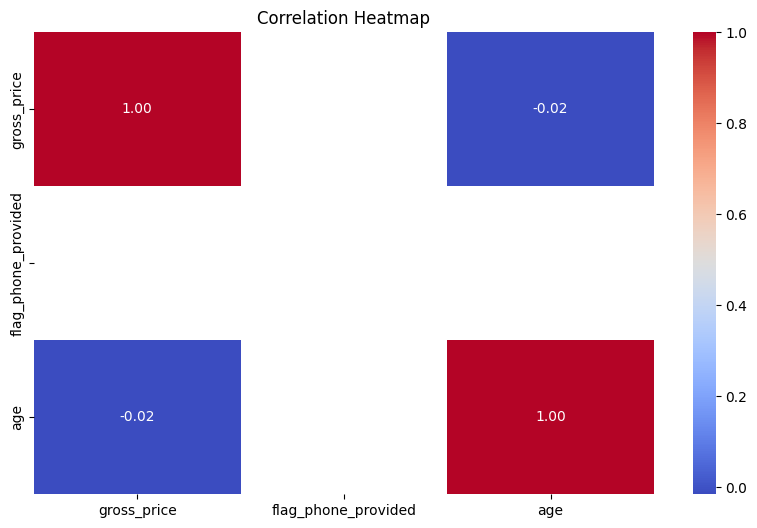

Customer Demographics Summary:
  Gender  Avg Gross Price  Total Gross Price  Order Count    Avg Age  Min Age  \
0      F        17.108734        24769153.00      1447749  46.452945       21   
1      M        16.784126        30218526.47      1800423  51.876471       22   

   Max Age  
0       94  
1       91  


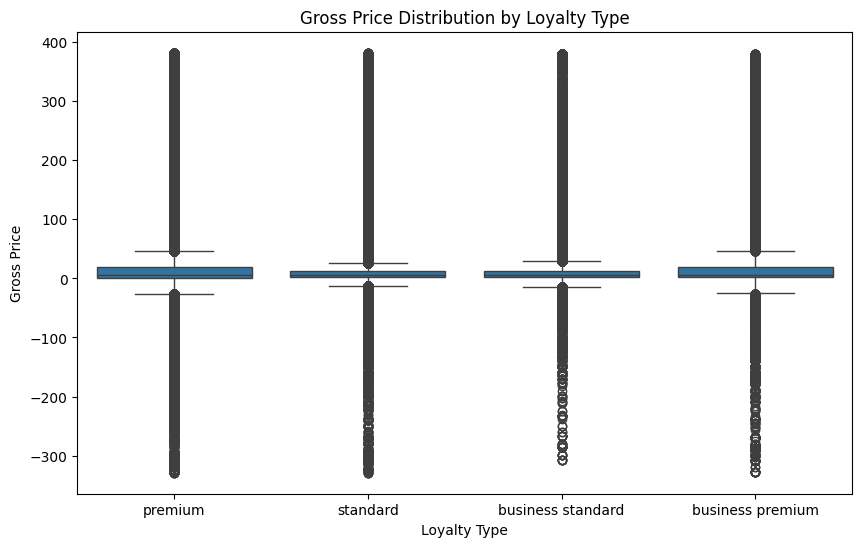

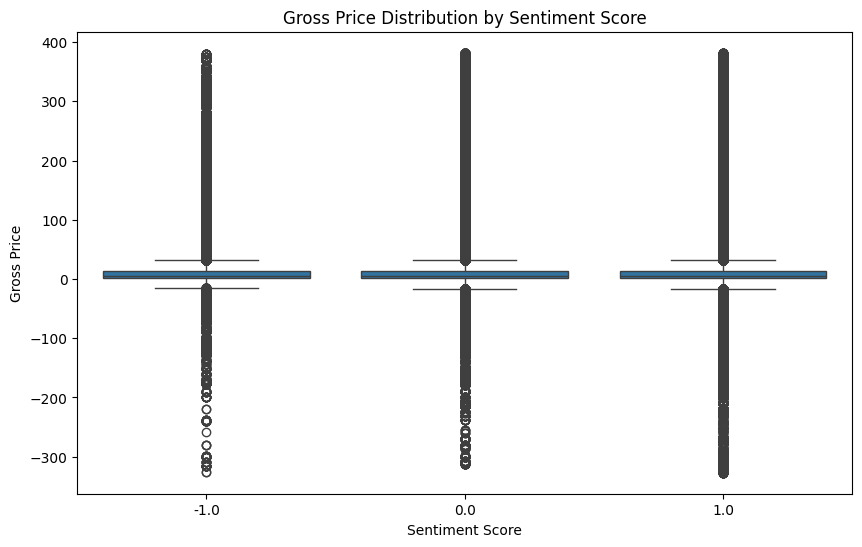

In [46]:
def generate_insights(merged_data):
    # Convert birthdate to age, ensuring birthdate is in datetime format
    if 'birthdate' in merged_data.columns:
        merged_data['birthdate'] = pd.to_datetime(merged_data['birthdate'], errors='coerce')
        current_year = pd.Timestamp.now().year
        merged_data['age'] = current_year - merged_data['birthdate'].dt.year
    
    # 2. Correlation Heatmap
    plt.figure(figsize=(10, 6))
    corr = merged_data[['gross_price', 'flag_phone_provided', 'age']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()
    
    # 3. Customer Demographics Summary
    demographics_summary = merged_data.groupby(['gender']).agg({
        'gross_price': ['mean', 'sum', 'count'],
        'age': ['mean', 'min', 'max']
    }).reset_index()
    demographics_summary.columns = ['Gender', 'Avg Gross Price', 'Total Gross Price', 'Order Count', 'Avg Age', 'Min Age', 'Max Age']
    print("Customer Demographics Summary:")
    print(demographics_summary)
    
    # 4. Loyalty Program Impact on Spending
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='loyalty_type', y='gross_price', data=merged_data)
    plt.title('Gross Price Distribution by Loyalty Type')
    plt.xlabel('Loyalty Type')
    plt.ylabel('Gross Price')
    plt.show()
    
    # 5. Sentiment Analysis of Product Reviews
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='sentiment_score', y='gross_price', data=merged_data)
    plt.title('Gross Price Distribution by Sentiment Score')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Gross Price')
    plt.show()

# Ensure 'age' is calculated correctly before generating insights
generate_insights(merged_data_corrected)


Customer Demographics Summary:
  Gender  Avg Gross Price  Total Gross Price  Order Count    Avg Age  Min Age  \
0      F        17.108734        24769153.00      1447749  46.452945       21   
1      M        16.784126        30218526.47      1800423  51.876471       22   

   Max Age  
0       94  
1       91  


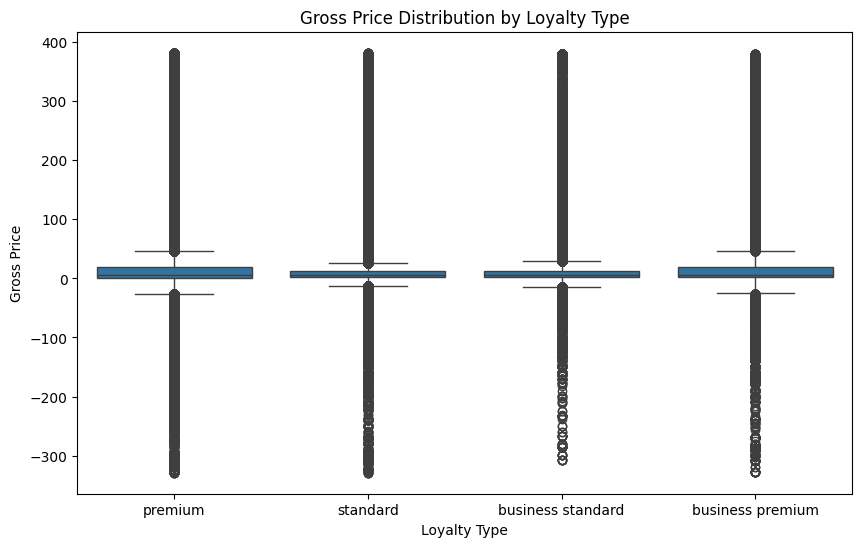

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

def generate_insights(merged_data: pd.DataFrame) -> None:
    """
    Generate various insights from the merged data including distribution, correlation, demographics summary, 
    loyalty program impact, sentiment analysis, product correlation, and differences across product categories by sex.
    """
    # Convert birthdate to age, ensuring birthdate is in datetime format
    if 'birthdate' in merged_data.columns:
        merged_data['birthdate'] = pd.to_datetime(merged_data['birthdate'], errors='coerce')
        current_year = pd.Timestamp.now().year
        merged_data['age'] = current_year - merged_data['birthdate'].dt.year
    
    # 3. Customer Demographics Summary
    demographics_summary = merged_data.groupby(['gender']).agg({
        'gross_price': ['mean', 'sum', 'count'],
        'age': ['mean', 'min', 'max']
    }).reset_index()
    demographics_summary.columns = ['Gender', 'Avg Gross Price', 'Total Gross Price', 'Order Count', 'Avg Age', 'Min Age', 'Max Age']
    print("Customer Demographics Summary:")
    print(demographics_summary)
    
    # 4. Loyalty Program Impact on Spending
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='loyalty_type', y='gross_price', data=merged_data)
    plt.title('Gross Price Distribution by Loyalty Type')
    plt.xlabel('Loyalty Type')
    plt.ylabel('Gross Price')
    plt.show()
    
    # 7. Differences Across Product Categories by Sex
    if 'product_category' in merged_data.columns and 'gender' in merged_data.columns:
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='product_category', y='gross_price', hue='gender', data=merged_data)
        plt.title('Gross Price Distribution by Product Category and Gender')
        plt.xlabel('Product Category')
        plt.ylabel('Gross Price')
        plt.xticks(rotation=45)
        plt.legend(title='Gender')
        plt.show()

# Ensure 'age' is calculated correctly before generating insights
generate_insights(merged_data_corrected)

merged_data.columns

Index(['order_id', 'customer_id', 'store_id', 'product_id', 'direction',
       'gross_price', 'price_reduction', 'purchase_datetime', 'product_class',
       'address_id', 'birthdate', 'gender', 'job_type', 'email_provider',
       'flag_phone_provided', 'flag_privacy', 'postal_code', 'district',
       'region', 'account_id', 'favorite_store', 'loyalty_type',
       'loyatlty_status', 'activation_date'],
      dtype='object')

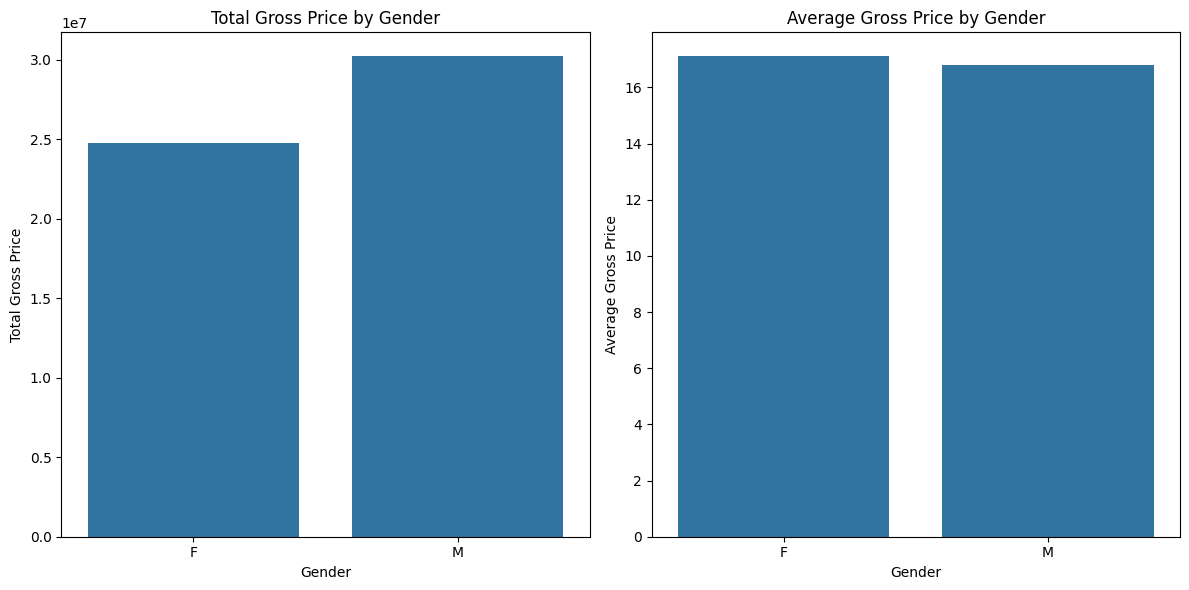

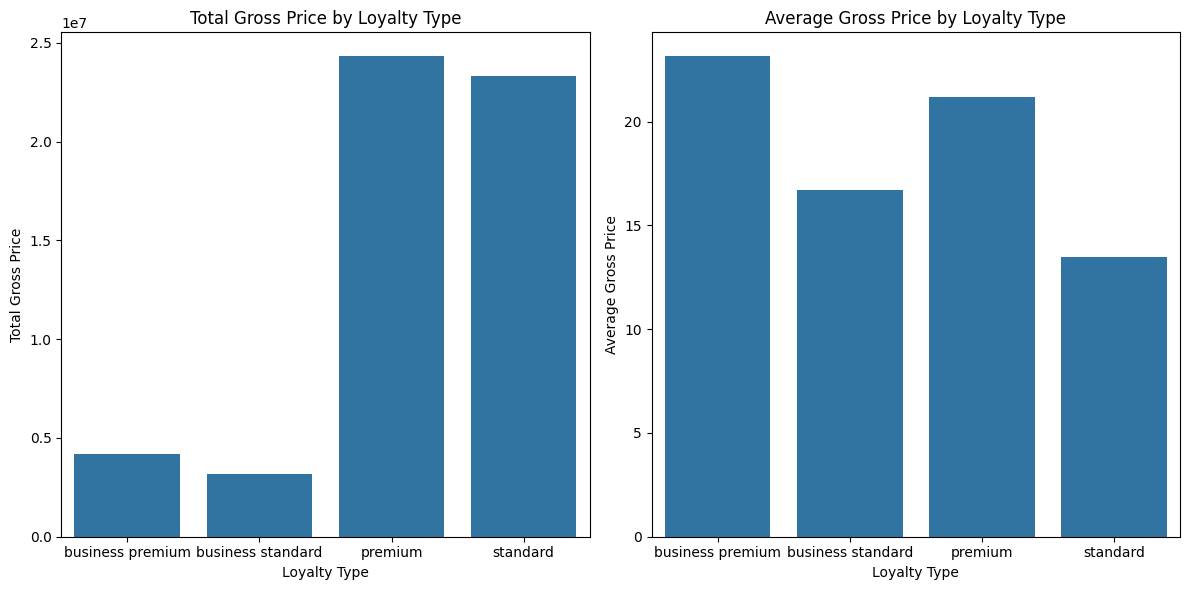

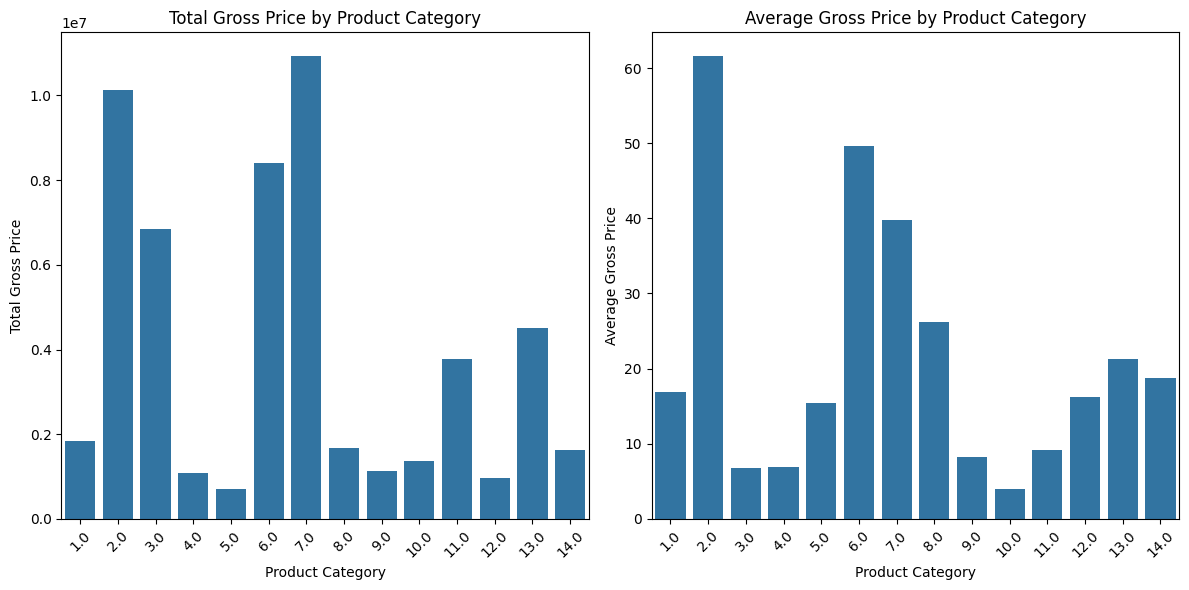

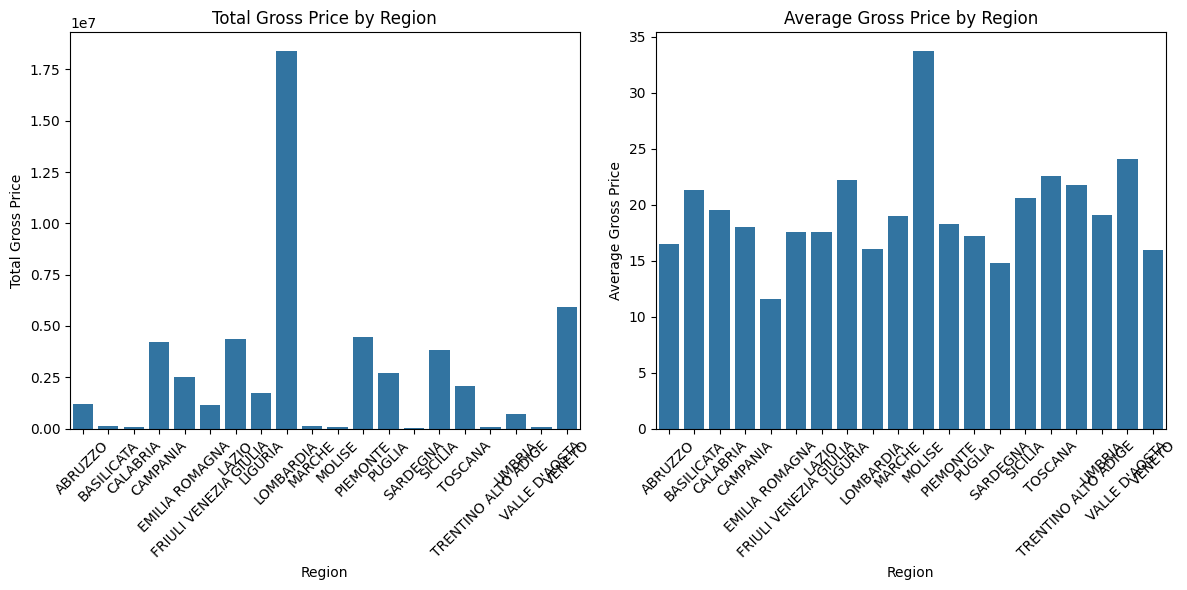

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def generate_aggregated_insights(merged_data: pd.DataFrame) -> None:
    """
    Generate insights from aggregated data including total and average gross price by gender, loyalty type, 
    product category, and region.
    """
    # 1. Total and Average Gross Price by Gender
    gender_agg = merged_data.groupby('gender').agg(
        total_gross_price=('gross_price', 'sum'),
        avg_gross_price=('gross_price', 'mean')
    ).reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='gender', y='total_gross_price', data=gender_agg)
    plt.title('Total Gross Price by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Total Gross Price')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='gender', y='avg_gross_price', data=gender_agg)
    plt.title('Average Gross Price by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Average Gross Price')
    plt.tight_layout()
    plt.show()
    
    # 2. Total and Average Gross Price by Loyalty Type
    loyalty_agg = merged_data.groupby('loyalty_type').agg(
        total_gross_price=('gross_price', 'sum'),
        avg_gross_price=('gross_price', 'mean')
    ).reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='loyalty_type', y='total_gross_price', data=loyalty_agg)
    plt.title('Total Gross Price by Loyalty Type')
    plt.xlabel('Loyalty Type')
    plt.ylabel('Total Gross Price')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='loyalty_type', y='avg_gross_price', data=loyalty_agg)
    plt.title('Average Gross Price by Loyalty Type')
    plt.xlabel('Loyalty Type')
    plt.ylabel('Average Gross Price')
    plt.tight_layout()
    plt.show()
    
    # 3. Total and Average Gross Price by Product Category
    product_category_agg = merged_data.groupby('product_class').agg(
        total_gross_price=('gross_price', 'sum'),
        avg_gross_price=('gross_price', 'mean')
    ).reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='product_class', y='total_gross_price', data=product_category_agg)
    plt.title('Total Gross Price by Product Category')
    plt.xlabel('Product Category')
    plt.ylabel('Total Gross Price')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='product_class', y='avg_gross_price', data=product_category_agg)
    plt.title('Average Gross Price by Product Category')
    plt.xlabel('Product Category')
    plt.ylabel('Average Gross Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Total and Average Gross Price by Region
    region_agg = merged_data.groupby('region').agg(
        total_gross_price=('gross_price', 'sum'),
        avg_gross_price=('gross_price', 'mean')
    ).reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='region', y='total_gross_price', data=region_agg)
    plt.title('Total Gross Price by Region')
    plt.xlabel('Region')
    plt.ylabel('Total Gross Price')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='region', y='avg_gross_price', data=region_agg)
    plt.title('Average Gross Price by Region')
    plt.xlabel('Region')
    plt.ylabel('Average Gross Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Ensure 'age' is calculated correctly before generating insights
generate_aggregated_insights(merged_data_corrected)

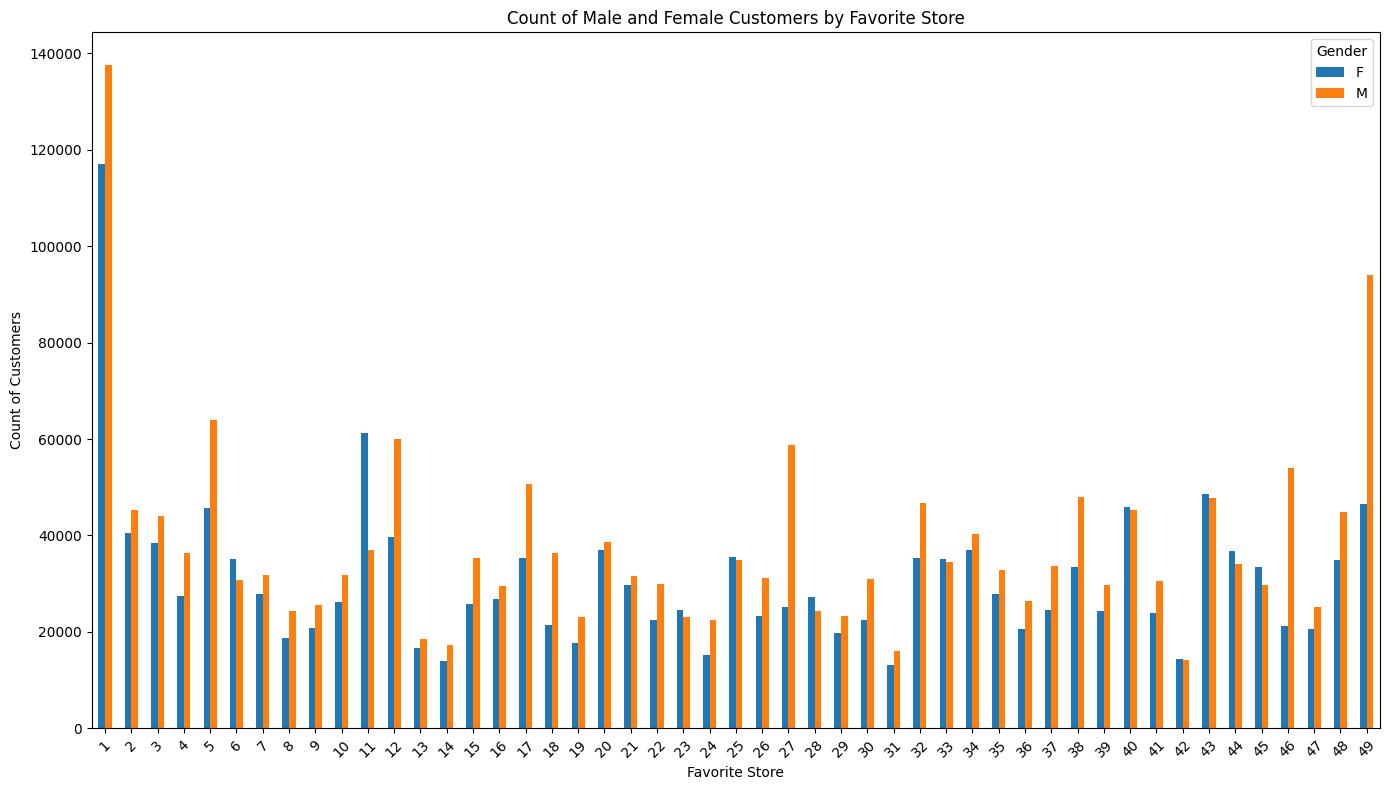

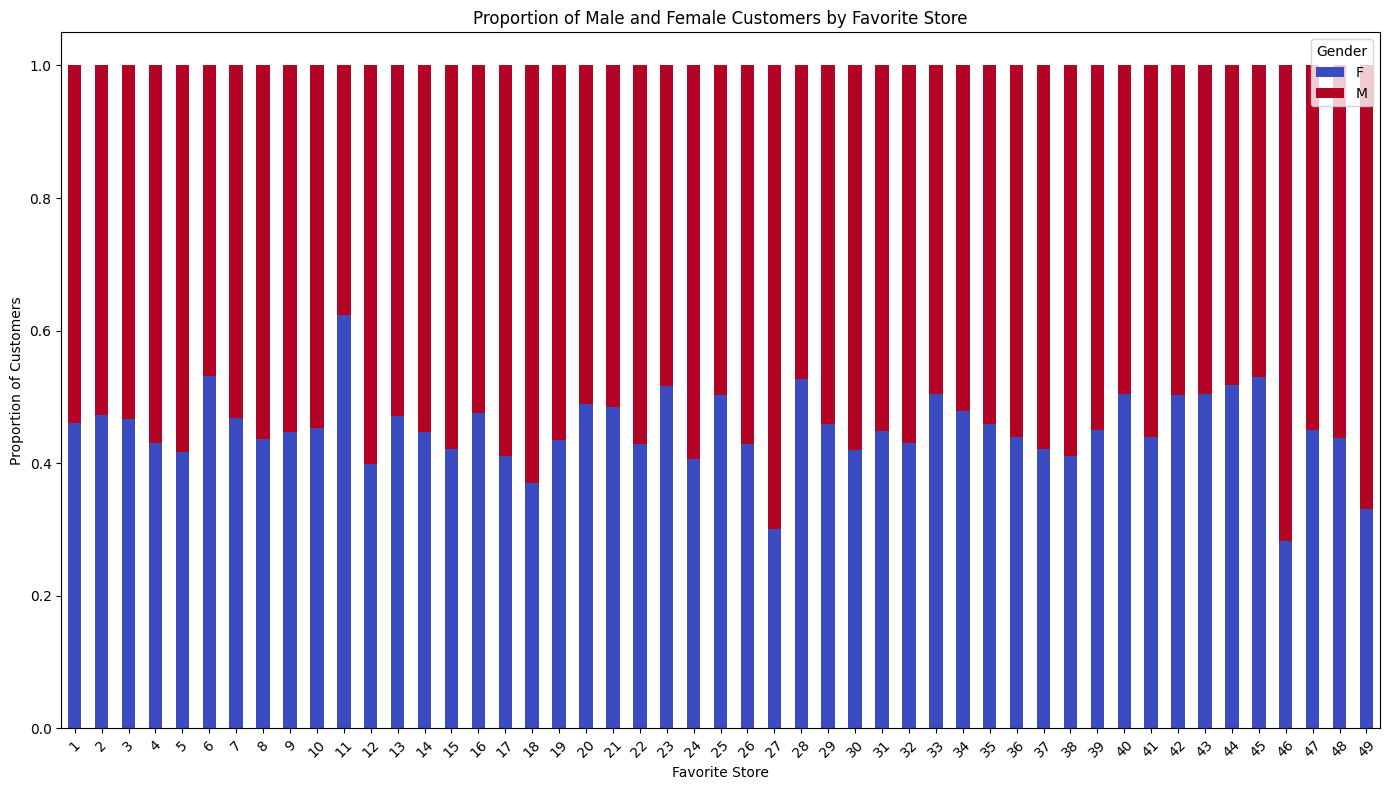

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_favorite_store_by_gender(merged_data: pd.DataFrame) -> None:
    """
    Analyze if there is a favorite store that has more male than female customers or vice versa.
    """
    # 1. Count the number of male and female customers for each favorite store
    store_gender_count = merged_data.groupby(['favorite_store', 'gender']).size().unstack(fill_value=0)
    
    # 2. Calculate the proportion of male and female customers for each favorite store
    store_gender_proportion = store_gender_count.div(store_gender_count.sum(axis=1), axis=0)
    
    # 3. Create a bar plot to show the count of male and female customers for each favorite store
    store_gender_count.plot(kind='bar', stacked=False, figsize=(14, 8))
    plt.title('Count of Male and Female Customers by Favorite Store')
    plt.xlabel('Favorite Store')
    plt.ylabel('Count of Customers')
    plt.xticks(rotation=45)
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.show()
    
    # 4. Create a stacked bar plot to show the proportion of male and female customers for each favorite store
    store_gender_proportion.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='coolwarm')
    plt.title('Proportion of Male and Female Customers by Favorite Store')
    plt.xlabel('Favorite Store')
    plt.ylabel('Proportion of Customers')
    plt.xticks(rotation=45)
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.show()

# Ensure 'age' is calculated correctly before generating insights
analyze_favorite_store_by_gender(merged_data_corrected)

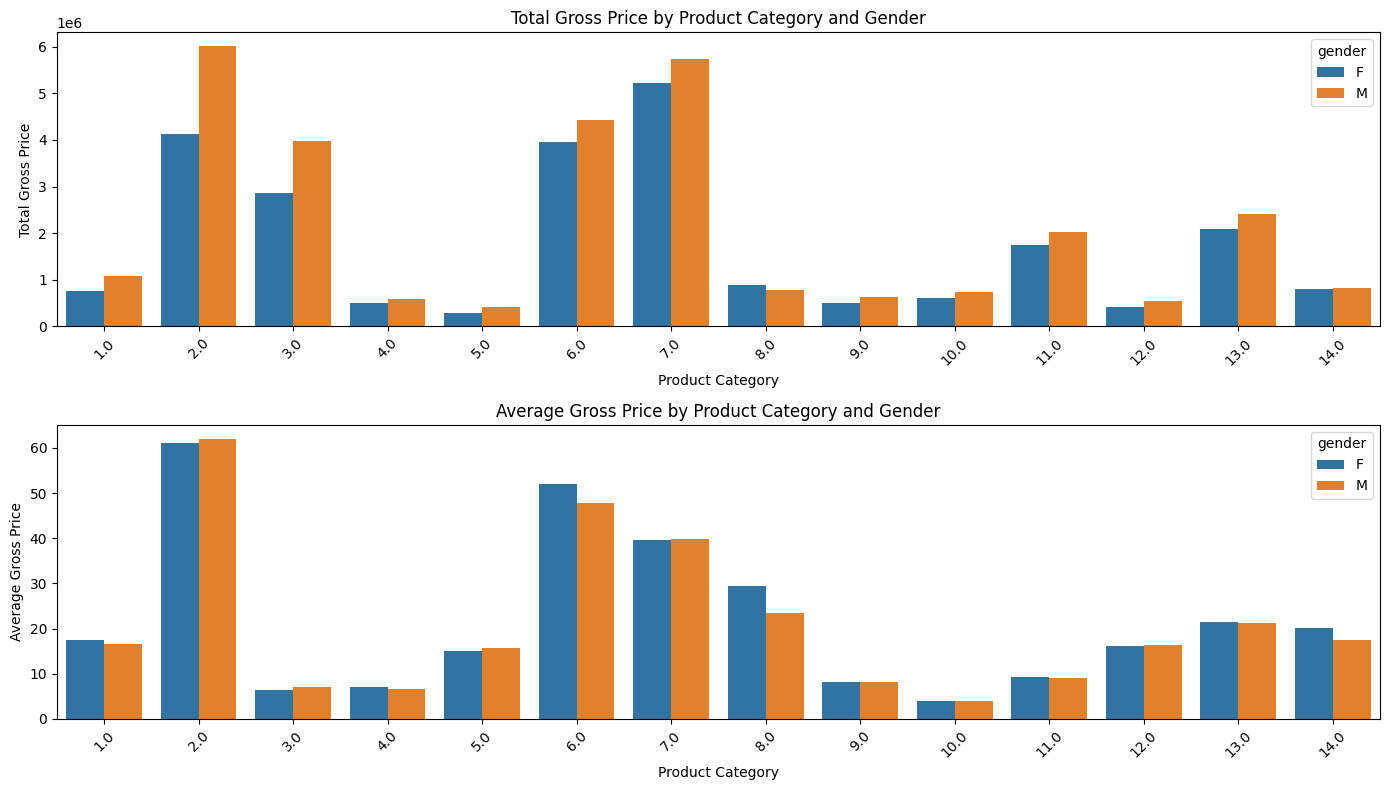

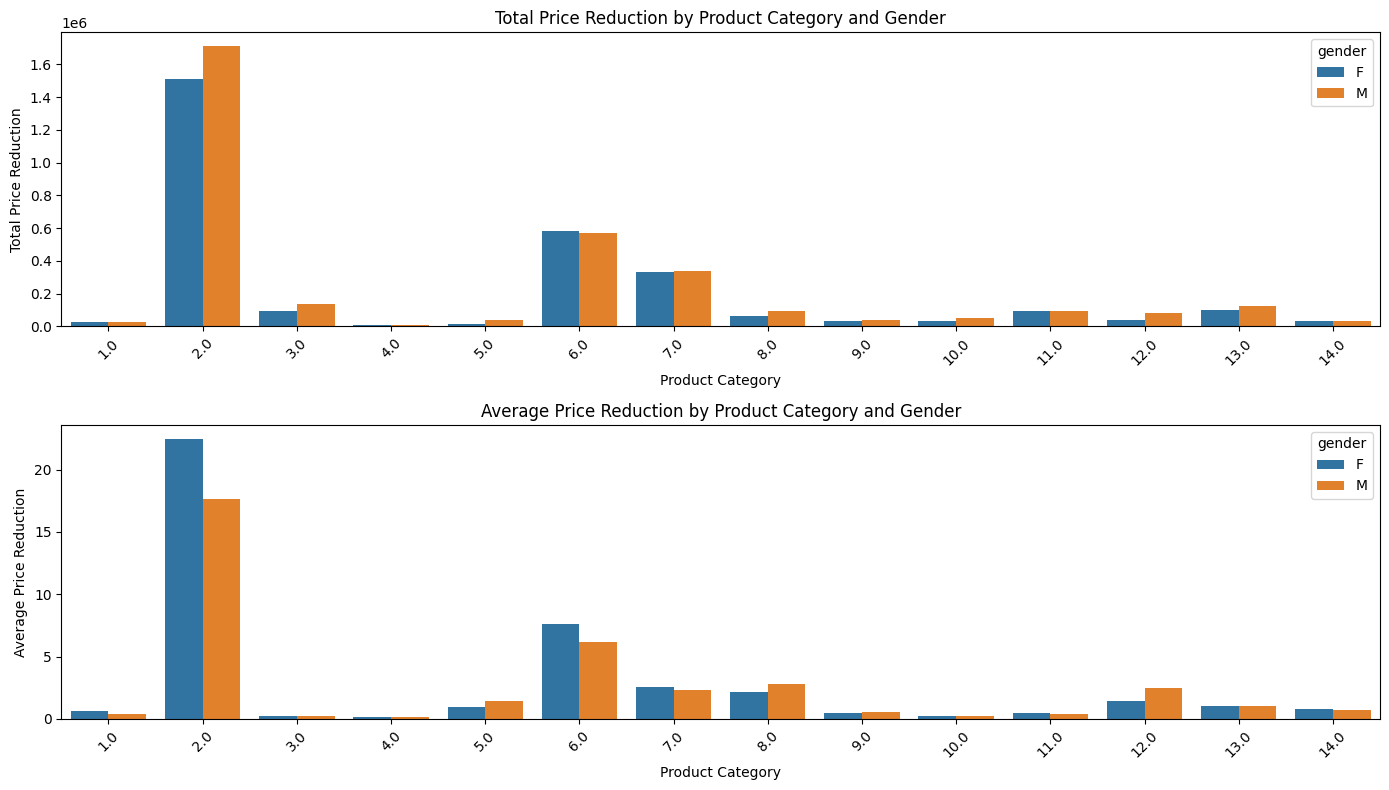

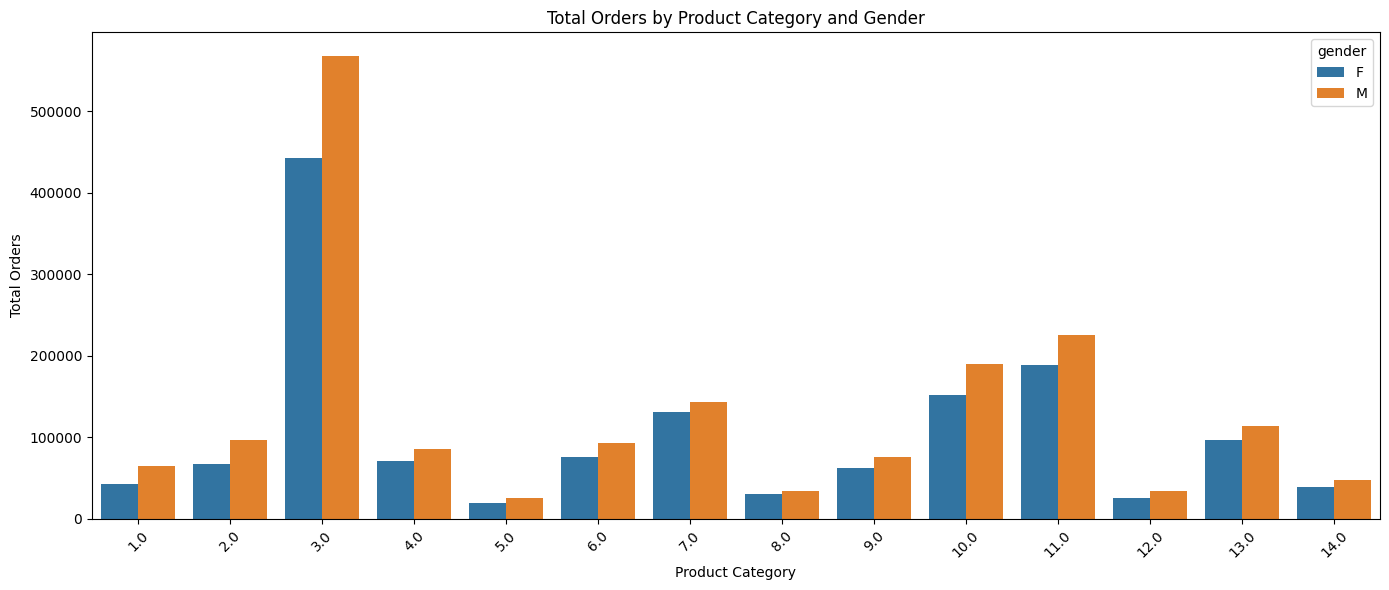

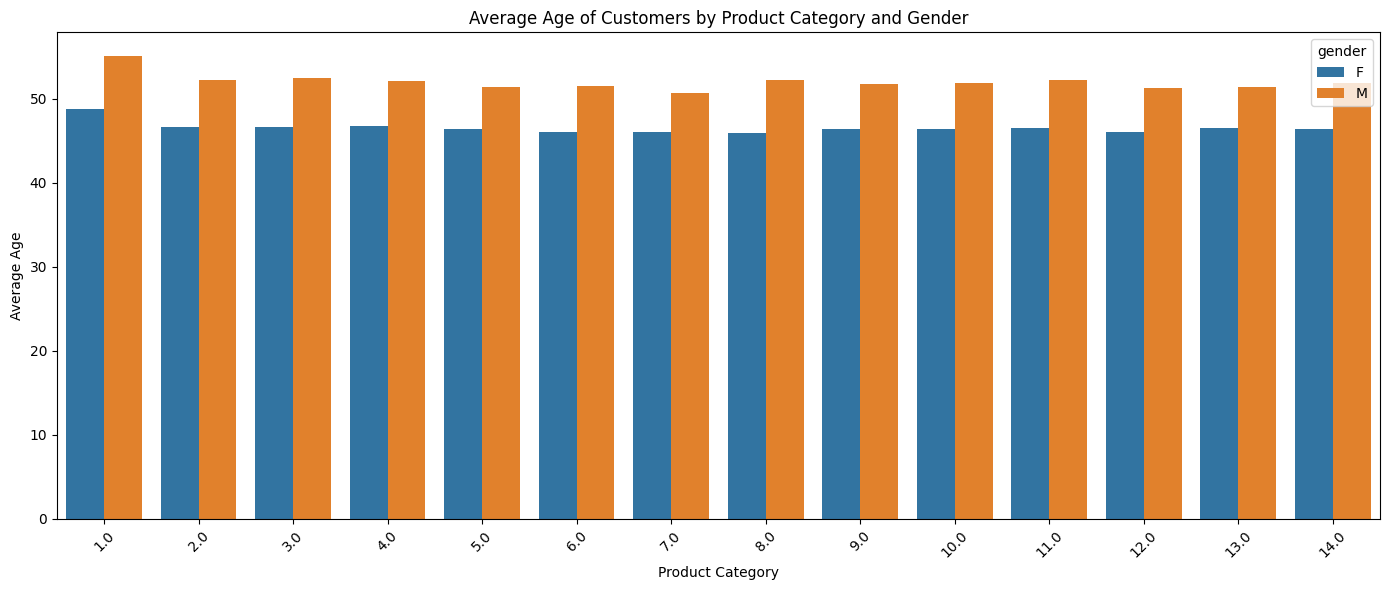

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_product_category_by_gender(merged_data: pd.DataFrame) -> None:
    """
    Analyze product category and shopping patterns divided by customer gender.
    """
    # 1. Total and Average Gross Price by Product Category and Gender
    category_gender_agg = merged_data.groupby(['product_class', 'gender']).agg(
        total_gross_price=('gross_price', 'sum'),
        avg_gross_price=('gross_price', 'mean')
    ).reset_index()
    
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    sns.barplot(x='product_class', y='total_gross_price', hue='gender', data=category_gender_agg)
    plt.title('Total Gross Price by Product Category and Gender')
    plt.xlabel('Product Category')
    plt.ylabel('Total Gross Price')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 1, 2)
    sns.barplot(x='product_class', y='avg_gross_price', hue='gender', data=category_gender_agg)
    plt.title('Average Gross Price by Product Category and Gender')
    plt.xlabel('Product Category')
    plt.ylabel('Average Gross Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Total and Average Price Reduction by Product Category and Gender
    price_reduction_agg = merged_data.groupby(['product_class', 'gender']).agg(
        total_price_reduction=('price_reduction', 'sum'),
        avg_price_reduction=('price_reduction', 'mean')
    ).reset_index()
    
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    sns.barplot(x='product_class', y='total_price_reduction', hue='gender', data=price_reduction_agg)
    plt.title('Total Price Reduction by Product Category and Gender')
    plt.xlabel('Product Category')
    plt.ylabel('Total Price Reduction')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 1, 2)
    sns.barplot(x='product_class', y='avg_price_reduction', hue='gender', data=price_reduction_agg)
    plt.title('Average Price Reduction by Product Category and Gender')
    plt.xlabel('Product Category')
    plt.ylabel('Average Price Reduction')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. Total Orders by Product Category and Gender
    orders_agg = merged_data.groupby(['product_class', 'gender']).agg(
        total_orders=('order_id', 'count')
    ).reset_index()
    
    plt.figure(figsize=(14, 6))
    sns.barplot(x='product_class', y='total_orders', hue='gender', data=orders_agg)
    plt.title('Total Orders by Product Category and Gender')
    plt.xlabel('Product Category')
    plt.ylabel('Total Orders')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Average Age of Customers by Product Category and Gender
    age_agg = merged_data.groupby(['product_class', 'gender']).agg(
        avg_age=('age', 'mean')
    ).reset_index()
    
    plt.figure(figsize=(14, 6))
    sns.barplot(x='product_class', y='avg_age', hue='gender', data=age_agg)
    plt.title('Average Age of Customers by Product Category and Gender')
    plt.xlabel('Product Category')
    plt.ylabel('Average Age')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Ensure 'age' is calculated correctly before generating insights
analyze_product_category_by_gender(merged_data_corrected)

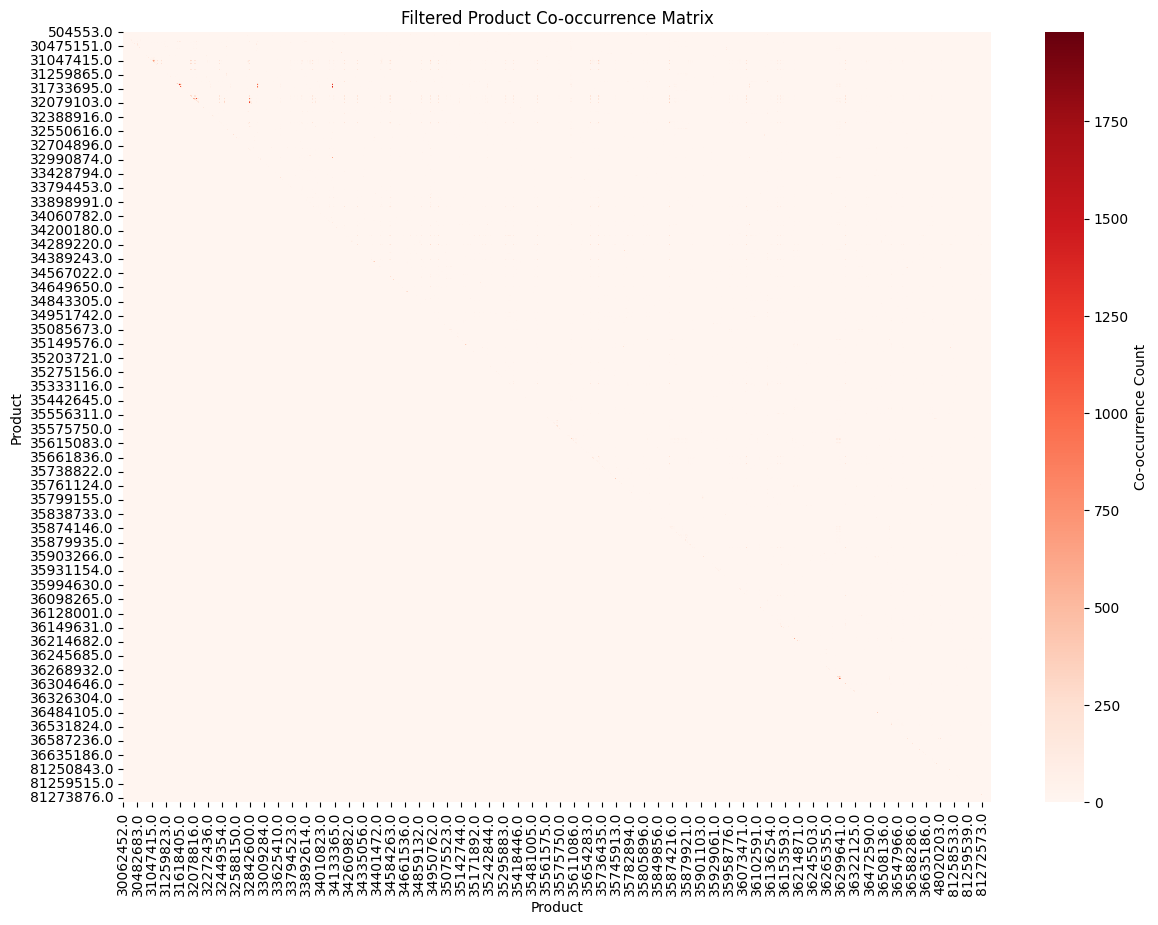

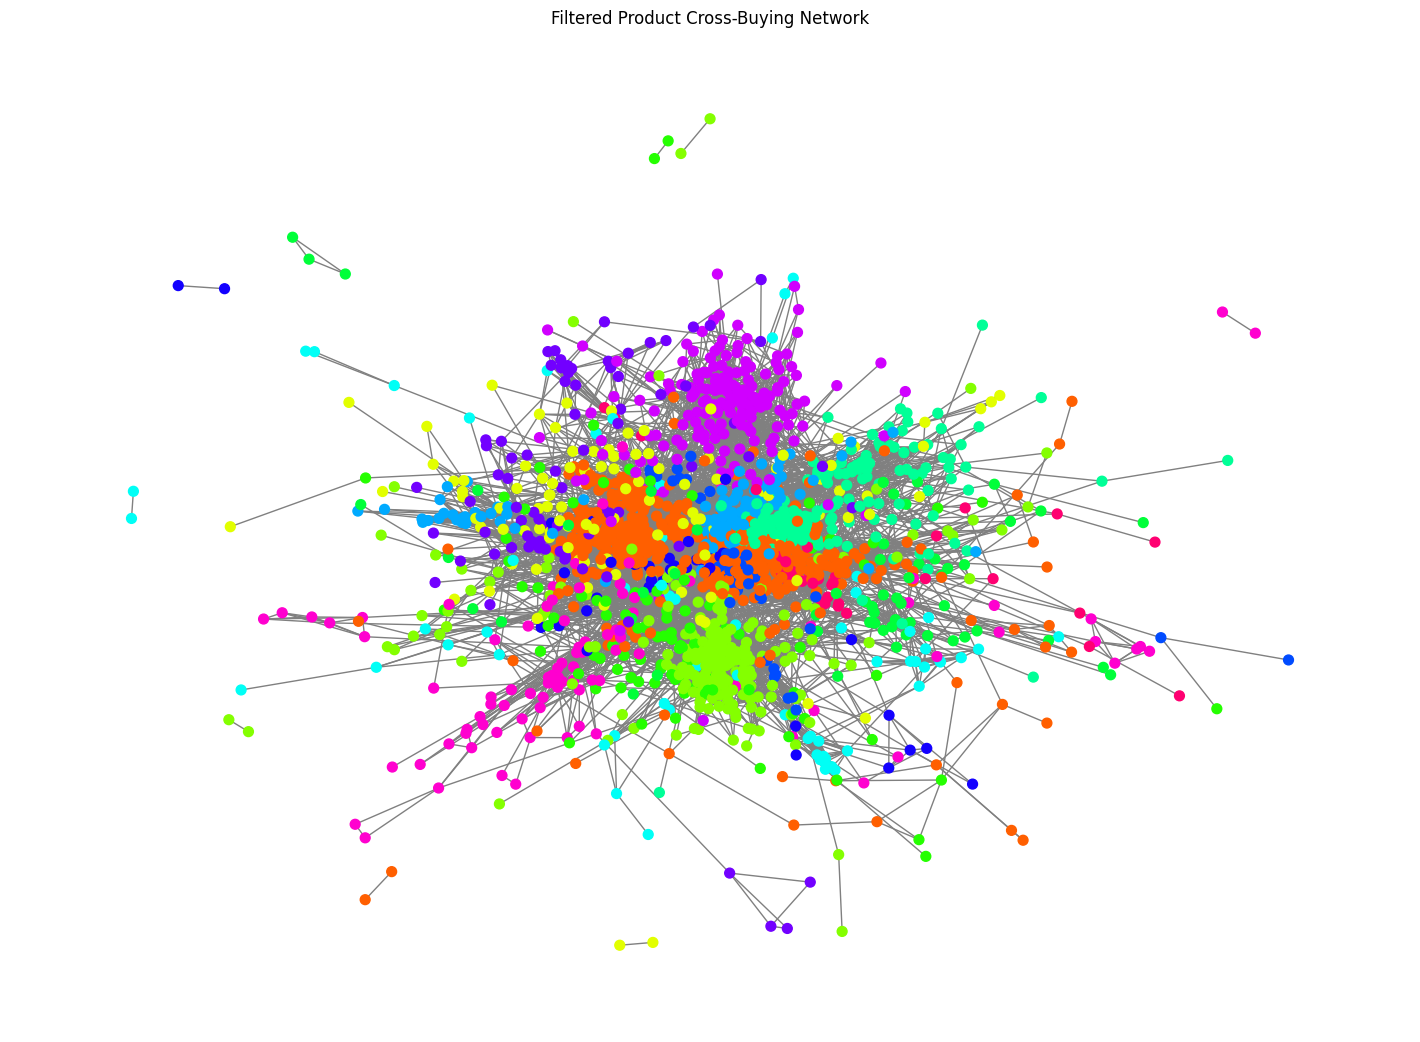

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

def analyze_cross_buying_patterns(merged_data: pd.DataFrame) -> None:
    """
    Analyze cross-buying patterns of products.
    """
    # 1. Create a co-occurrence matrix
    product_data = merged_data.groupby('order_id')['product_id'].apply(list).reset_index()
    product_data['product_id'] = product_data['product_id'].apply(lambda x: list(set(x)))  # Remove duplicates within the same order
    
    # Create a product co-occurrence matrix
    from itertools import combinations
    from collections import defaultdict
    
    co_occurrence = defaultdict(int)
    for products in product_data['product_id']:
        for combo in combinations(products, 2):
            co_occurrence[tuple(sorted(combo))] += 1
    
    co_occurrence_df = pd.DataFrame(list(co_occurrence.items()), columns=['product_pair', 'count'])
    co_occurrence_df[['product_1', 'product_2']] = pd.DataFrame(co_occurrence_df['product_pair'].tolist(), index=co_occurrence_df.index)
    co_occurrence_matrix = co_occurrence_df.pivot(index='product_1', columns='product_2', values='count').fillna(0)
    
    # 2. Calculate the lift for each pair of products
    product_counts = merged_data['product_id'].value_counts()
    total_orders = len(product_data)
    
    def calculate_lift(row):
        product_1 = row['product_1']
        product_2 = row['product_2']
        count_1 = product_counts[product_1]
        count_2 = product_counts[product_2]
        return (row['count'] / total_orders) / ((count_1 / total_orders) * (count_2 / total_orders))

    co_occurrence_df['lift'] = co_occurrence_df.apply(calculate_lift, axis=1)
    
    # 3. Filter by lift threshold (increase the threshold for the graph)
    lift_threshold_heatmap = co_occurrence_df['lift'].quantile(0.75)
    lift_threshold_graph = co_occurrence_df['lift'].quantile(0.95)  # Increased threshold
    filtered_co_occurrence_df_heatmap = co_occurrence_df[co_occurrence_df['lift'] > lift_threshold_heatmap]
    filtered_co_occurrence_df_graph = co_occurrence_df[co_occurrence_df['lift'] > lift_threshold_graph]
    
    # Create a filtered co-occurrence matrix for the heatmap
    filtered_co_occurrence_matrix = filtered_co_occurrence_df_heatmap.pivot(index='product_1', columns='product_2', values='count').fillna(0)
    
    # 4. Create a heatmap to visualize the filtered co-occurrence matrix
    plt.figure(figsize=(14, 10))
    cmap = sns.color_palette("Reds", as_cmap=True)
    sns.heatmap(filtered_co_occurrence_matrix, cmap=cmap, cbar_kws={'label': 'Co-occurrence Count'})
    plt.title('Filtered Product Co-occurrence Matrix')
    plt.xlabel('Product')
    plt.ylabel('Product')
    plt.show()
    
    # 5. Create a network graph to visualize the relationships between products
    G = nx.Graph()
    
    for _, row in filtered_co_occurrence_df_graph.iterrows():
        G.add_edge(row['product_1'], row['product_2'], weight=row['lift'])
    
    # Get unique product classes and assign colors
    product_classes = merged_data[['product_id', 'product_class']].drop_duplicates().set_index('product_id')
    unique_classes = product_classes['product_class'].unique()
    class_colors = sns.color_palette("hsv", len(unique_classes))
    class_color_map = dict(zip(unique_classes, class_colors))
    
    # Assign colors to nodes based on product class
    node_colors = [class_color_map[product_classes.loc[node]['product_class']] for node in G.nodes]
    
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=0.1)
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, font_size=10, edge_color='gray')
    plt.title('Filtered Product Cross-Buying Network')
    plt.show()

# Ensure 'age' is calculated correctly before generating insights
analyze_cross_buying_patterns(merged_data_corrected)

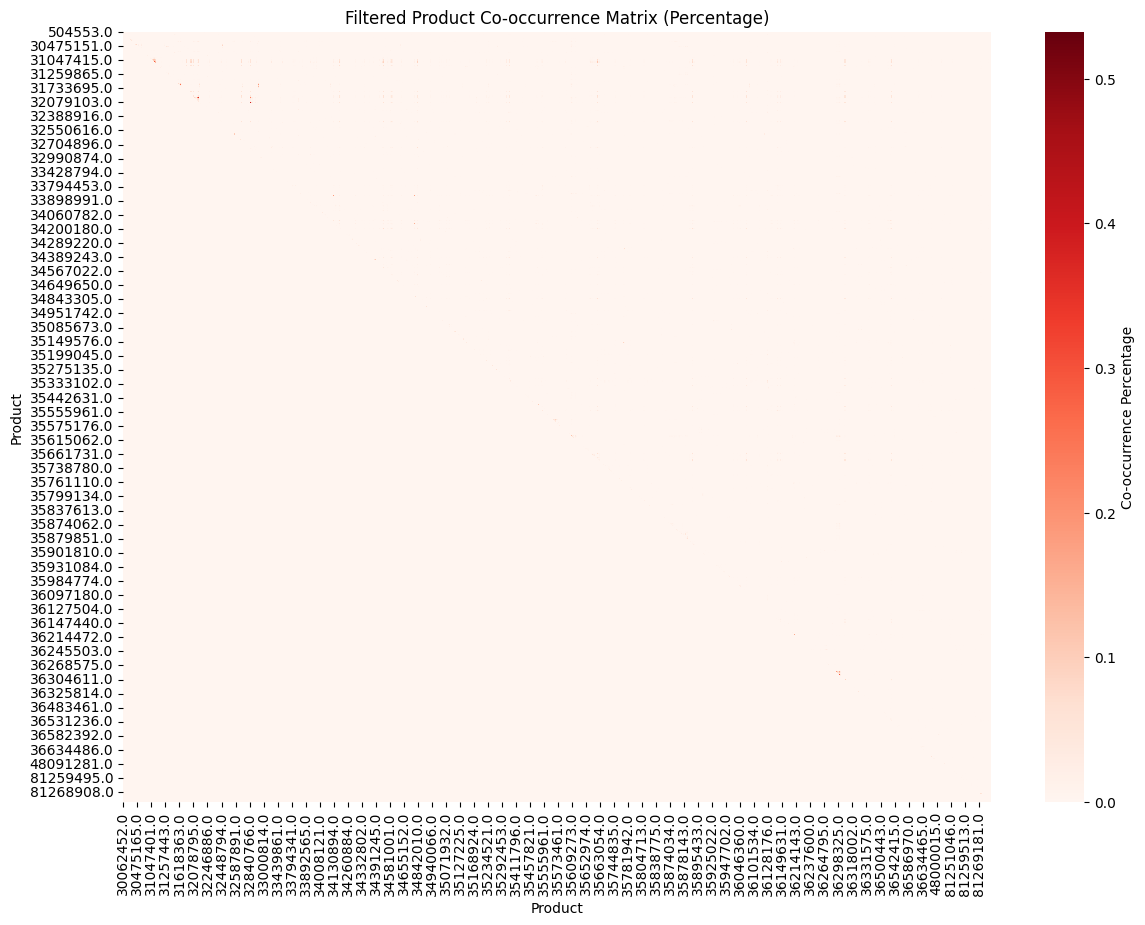

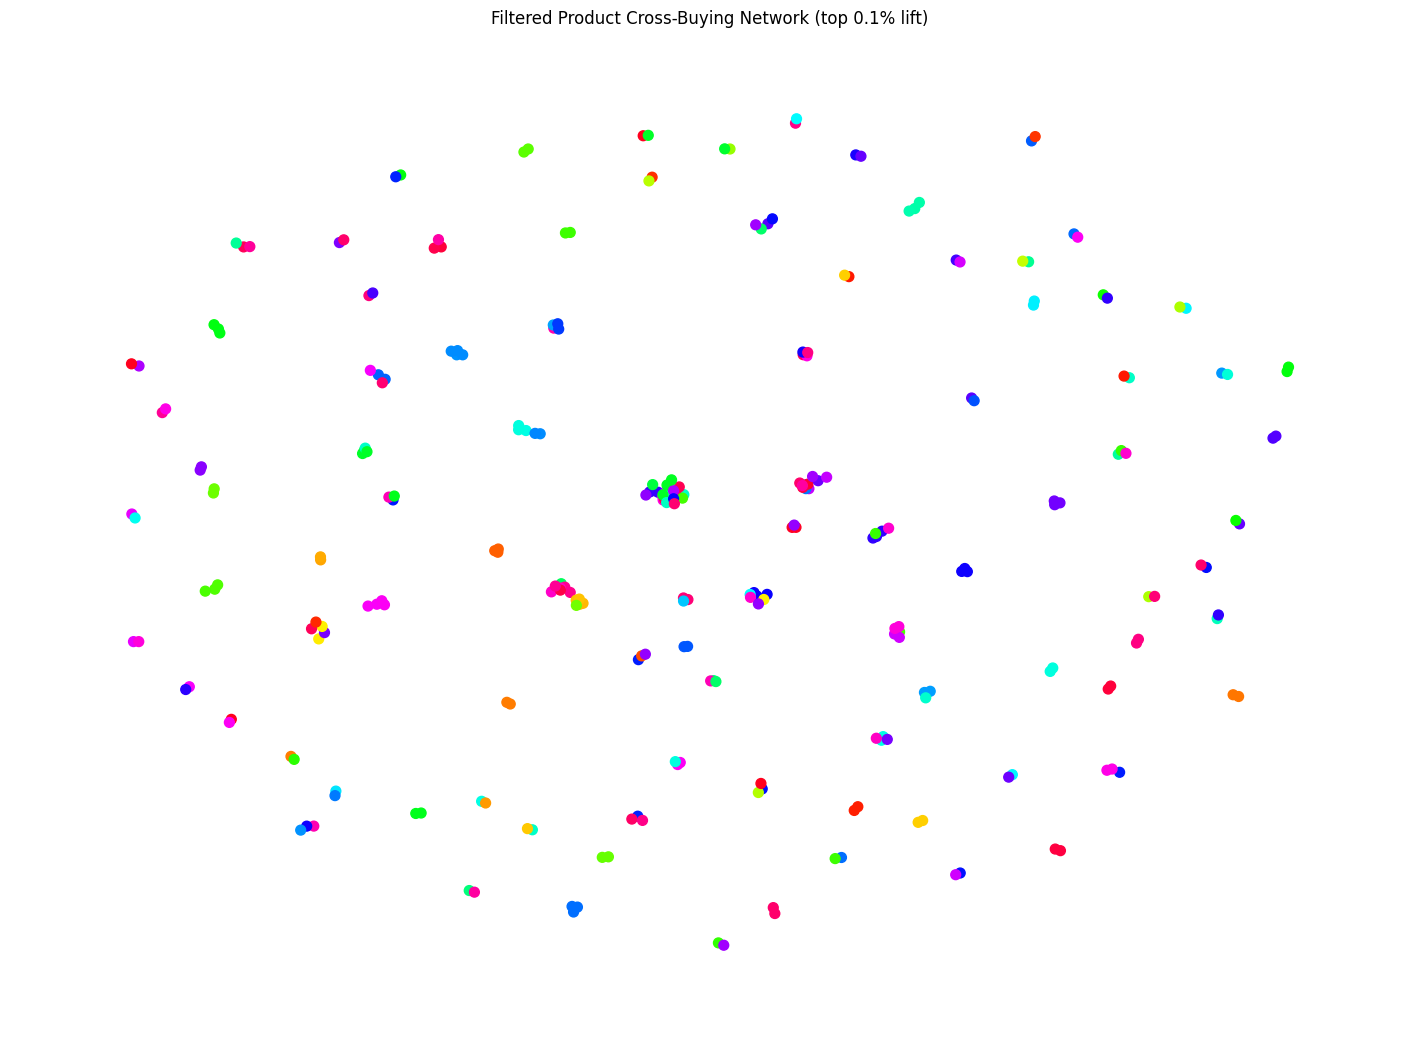

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

def analyze_cross_buying_patterns_by_product(merged_data: pd.DataFrame) -> None:
    category_data = merged_data.groupby('order_id')['product_id'].apply(list).reset_index()
    category_data['product_id'] = category_data['product_id'].apply(lambda x: list(set(x)))
    
    from itertools import combinations
    from collections import defaultdict
    
    co_occurrence = defaultdict(int)
    for products in category_data['product_id']:
        for combo in combinations(products, 2):
            co_occurrence[tuple(sorted(combo))] += 1
    
    co_occurrence_df = pd.DataFrame(list(co_occurrence.items()), columns=['product_pair', 'count'])
    co_occurrence_df[['product_1', 'product_2']] = pd.DataFrame(co_occurrence_df['product_pair'].tolist(), index=co_occurrence_df.index)
    
    total_orders = len(category_data)
    co_occurrence_df['percentage'] = co_occurrence_df['count'] / total_orders * 100
    
    percentage_co_occurrence_matrix = co_occurrence_df.pivot(index='product_1', columns='product_2', values='percentage').fillna(0)
    
    product_counts = merged_data['product_id'].value_counts()
    
    def calculate_lift(row):
        product_1 = row['product_1']
        product_2 = row['product_2']
        count_1 = product_counts[product_1]
        count_2 = product_counts[product_2]
        return (row['count'] / total_orders) / ((count_1 / total_orders) * (count_2 / total_orders))

    co_occurrence_df['lift'] = co_occurrence_df.apply(calculate_lift, axis=1)
    
    lift_threshold_heatmap = co_occurrence_df['lift'].quantile(0.65)
    lift_threshold_graph = co_occurrence_df['lift'].quantile(0.999)
    filtered_co_occurrence_df_heatmap = co_occurrence_df[co_occurrence_df['lift'] > lift_threshold_heatmap]
    filtered_co_occurrence_df_graph = co_occurrence_df[co_occurrence_df['lift'] > lift_threshold_graph]
    
    filtered_percentage_co_occurrence_matrix = filtered_co_occurrence_df_heatmap.pivot(index='product_1', columns='product_2', values='percentage').fillna(0)
    
    plt.figure(figsize=(14, 10))
    cmap = sns.color_palette("Reds", as_cmap=True)
    sns.heatmap(filtered_percentage_co_occurrence_matrix, cmap=cmap, cbar_kws={'label': 'Co-occurrence Percentage'})
    plt.title('Filtered Product Co-occurrence Matrix (Percentage)')
    plt.xlabel('Product')
    plt.ylabel('Product')
    plt.show()
    
    G = nx.Graph()
    
    for _, row in filtered_co_occurrence_df_graph.iterrows():
        G.add_edge(row['product_1'], row['product_2'], weight=row['lift'])
    
    unique_products = merged_data['product_id'].unique()
    product_colors = sns.color_palette("hsv", len(unique_products))
    product_color_map = dict(zip(unique_products, product_colors))
    
    node_colors = [product_color_map[node] for node in G.nodes]
    
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=0.1)
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, font_size=10, edge_color='gray')
    plt.title('Filtered Product Cross-Buying Network (top 0.1% lift)')
    plt.show()

analyze_cross_buying_patterns_by_product(merged_data_corrected)

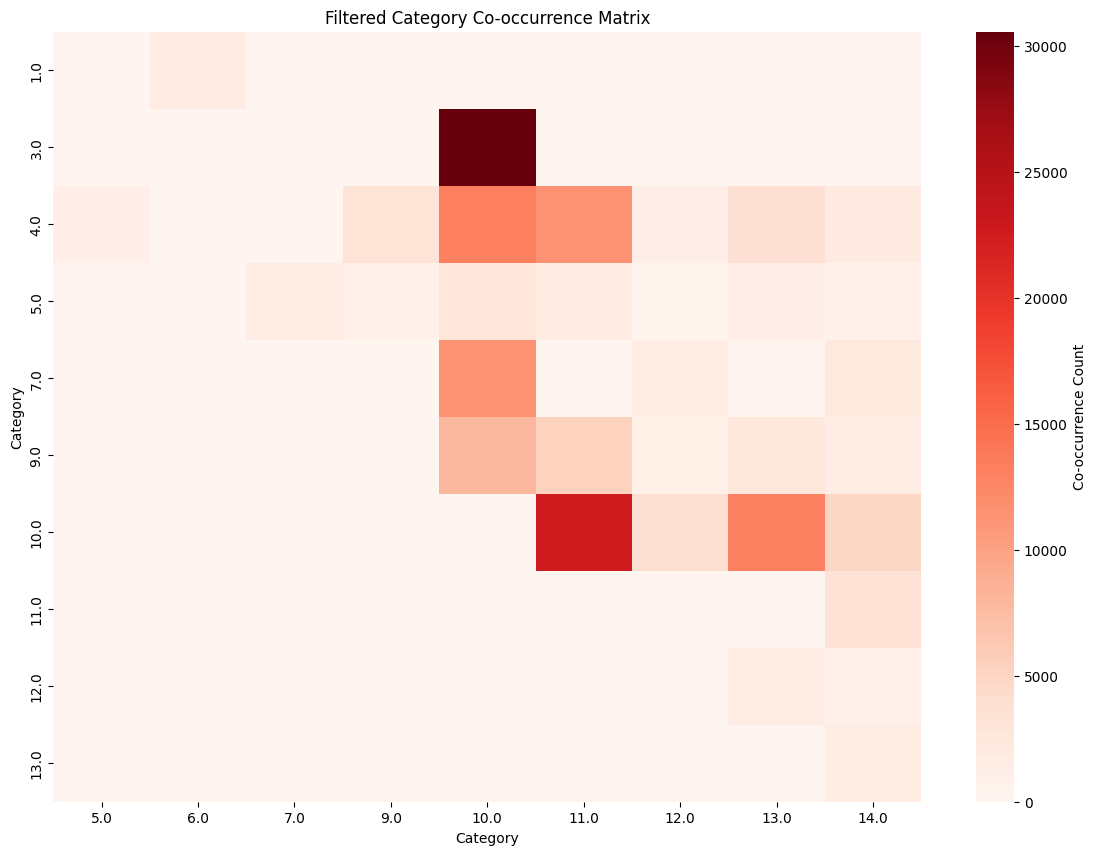

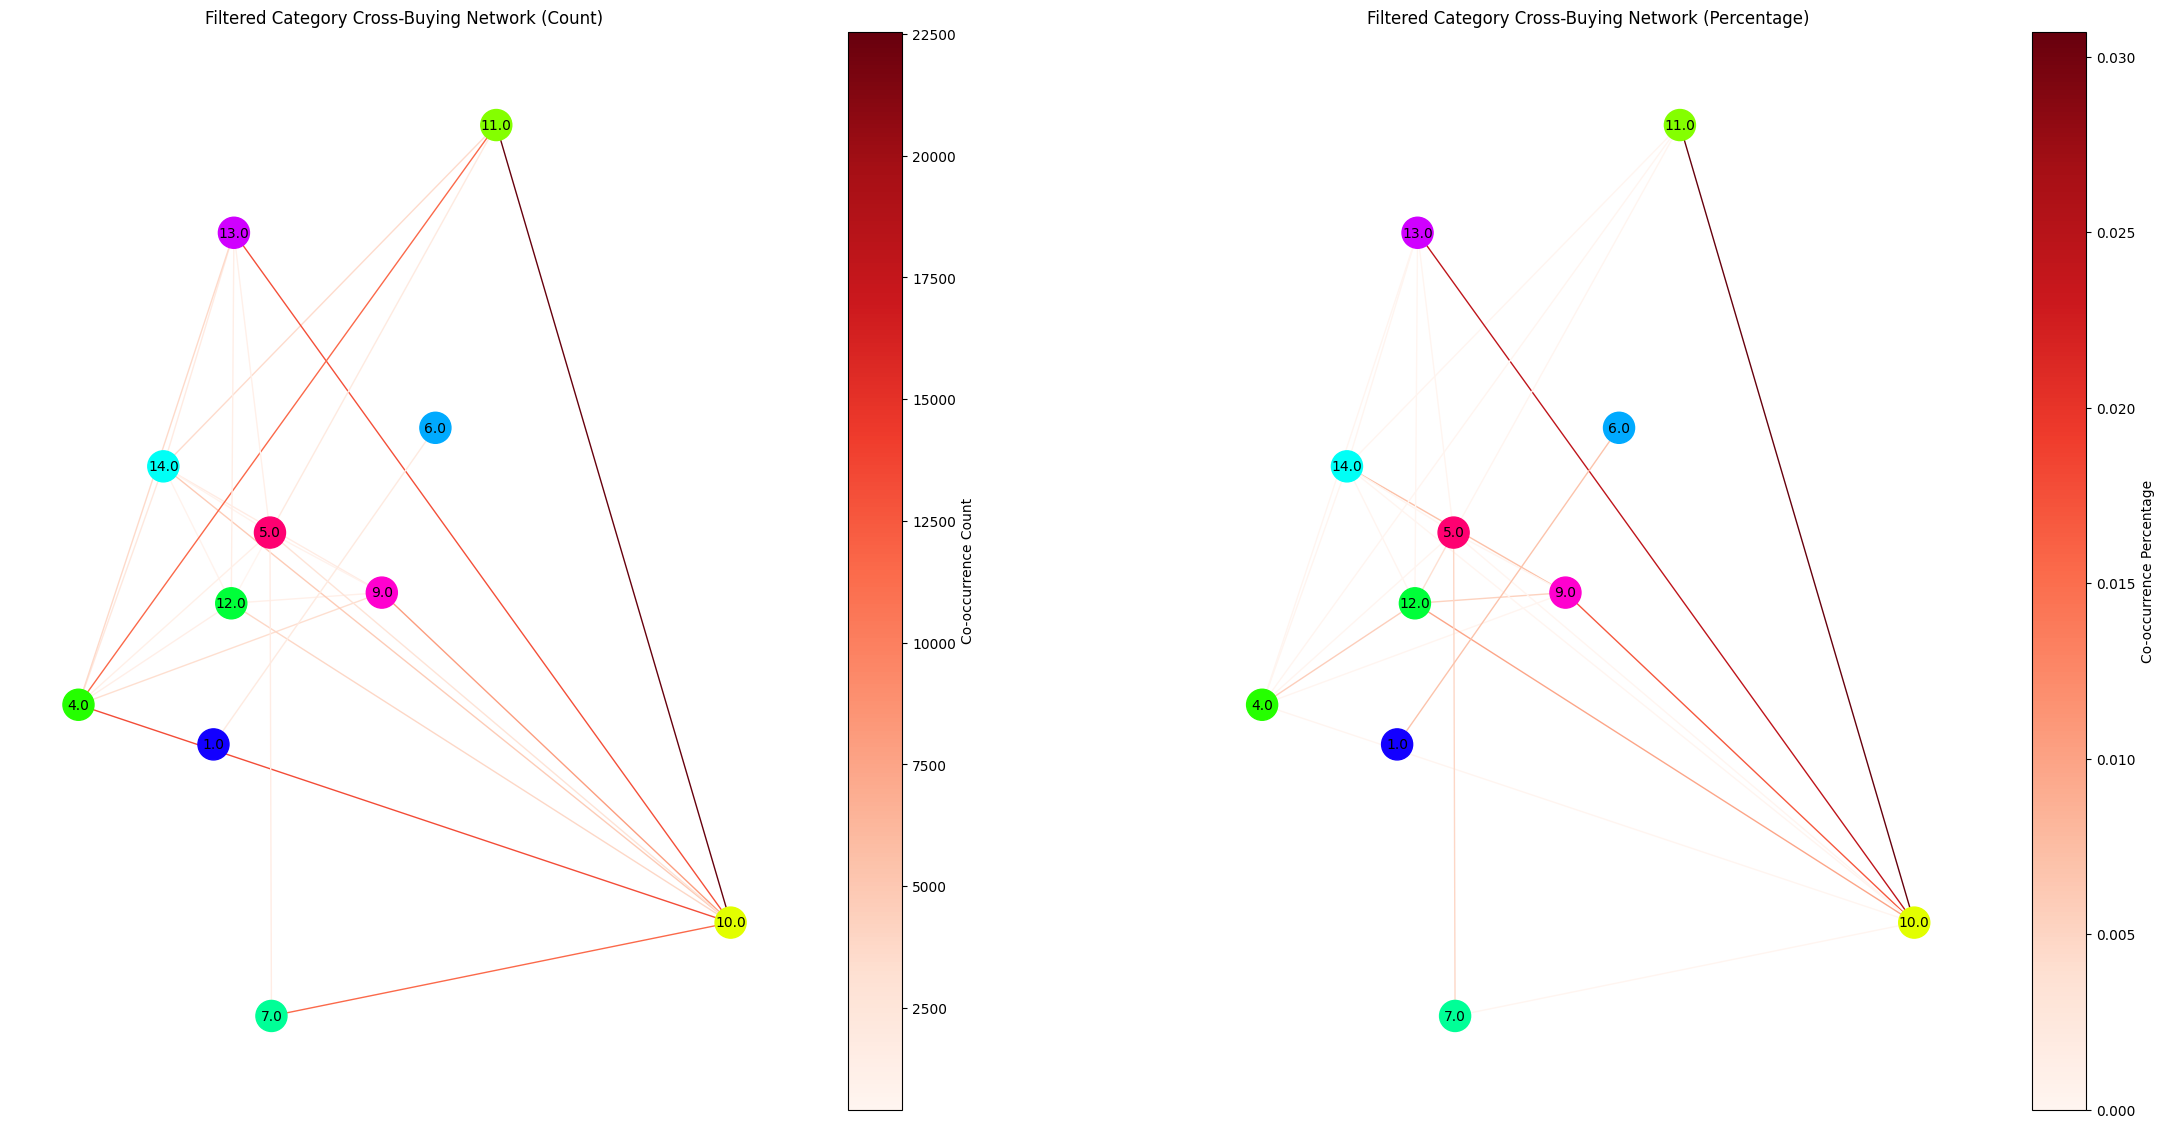

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def analyze_cross_buying_patterns_by_category(merged_data: pd.DataFrame) -> None:
    """
    Analyze cross-buying patterns of product categories.
    """
    # 1. Group by product categories
    merged_data['product_category'] = merged_data['product_class']  # Assuming 'product_class' is the category
    category_data = merged_data.groupby('order_id')['product_category'].apply(list).reset_index()
    category_data['product_category'] = category_data['product_category'].apply(lambda x: list(set(x)))  # Remove duplicates within the same order
    
    # Create a category co-occurrence matrix
    from itertools import combinations
    from collections import defaultdict
    
    co_occurrence = defaultdict(int)
    for categories in category_data['product_category']:
        for combo in combinations(categories, 2):
            co_occurrence[tuple(sorted(combo))] += 1
    
    co_occurrence_df = pd.DataFrame(list(co_occurrence.items()), columns=['category_pair', 'count'])
    co_occurrence_df[['category_1', 'category_2']] = pd.DataFrame(co_occurrence_df['category_pair'].tolist(), index=co_occurrence_df.index)
    co_occurrence_matrix = co_occurrence_df.pivot(index='category_1', columns='category_2', values='count').fillna(0)
    
    # 2. Calculate the lift for each pair of categories
    category_counts = merged_data['product_category'].value_counts()
    total_orders = len(category_data)
    
    def calculate_lift(row):
        category_1 = row['category_1']
        category_2 = row['category_2']
        count_1 = category_counts[category_1]
        count_2 = category_counts[category_2]
        return (row['count'] / total_orders) / ((count_1 / total_orders) * (count_2 / total_orders))

    co_occurrence_df['lift'] = co_occurrence_df.apply(calculate_lift, axis=1)
    
    # 3. Filter by lift threshold (90th percentile for the graph)
    lift_threshold_heatmap = co_occurrence_df['lift'].quantile(0.65)
    lift_threshold_graph = co_occurrence_df['lift'].quantile(0.70)
    filtered_co_occurrence_df_heatmap = co_occurrence_df[co_occurrence_df['lift'] > lift_threshold_heatmap]
    filtered_co_occurrence_df_graph = co_occurrence_df[co_occurrence_df['lift'] > lift_threshold_graph]
    
    # Create a filtered co-occurrence matrix for the heatmap
    filtered_co_occurrence_matrix = filtered_co_occurrence_df_heatmap.pivot(index='category_1', columns='category_2', values='count').fillna(0)
    
    # 4. Create a heatmap to visualize the filtered co-occurrence matrix
    plt.figure(figsize=(14, 10))
    cmap = sns.color_palette("Reds", as_cmap=True)
    sns.heatmap(filtered_co_occurrence_matrix, cmap=cmap, cbar_kws={'label': 'Co-occurrence Count'})
    plt.title('Filtered Category Co-occurrence Matrix')
    plt.xlabel('Category')
    plt.ylabel('Category')
    plt.show()
    
    # 5. Create a network graph to visualize the relationships between categories based on count
    G = nx.Graph()
    
    for _, row in filtered_co_occurrence_df_graph.iterrows():
        G.add_edge(row['category_1'], row['category_2'], weight=row['count'])
    
    # Assign colors to nodes based on categories
    unique_categories = merged_data['product_category'].unique()
    category_colors = sns.color_palette("hsv", len(unique_categories))
    category_color_map = dict(zip(unique_categories, category_colors))
    
    node_colors = [category_color_map[node] for node in G.nodes]
    
    # Normalize edge weights for color mapping
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]
    norm = Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
    cmap = plt.cm.Reds
    edge_colors = [cmap(norm(G[u][v]['weight'])) for u, v in G.edges]
    
    # 6. Create a network graph to visualize the relationships between categories based on percentage
    G_percentage = nx.Graph()
    
    for _, row in filtered_co_occurrence_df_graph.iterrows():
        G_percentage.add_edge(row['category_1'], row['category_2'], weight=row['count'])
    
    # Calculate the percentage of times products are bought together
    def calculate_percentage(row):
        category_1 = row['category_1']
        category_2 = row['category_2']
        count_1 = category_counts[category_1]
        count_2 = category_counts[category_2]
        return row['count'] / (count_1 + count_2 - row['count'])

    co_occurrence_df['percentage'] = co_occurrence_df.apply(calculate_percentage, axis=1)
    
    # Normalize edge weights for color mapping
    edge_weights_percentage = [G_percentage[u][v]['weight'] for u, v in G_percentage.edges]
    edge_percentages = []
    for u, v in G_percentage.edges:
        percentage = co_occurrence_df[(co_occurrence_df['category_1'] == u) & (co_occurrence_df['category_2'] == v)]['percentage']
        if not percentage.empty:
            edge_percentages.append(percentage.values[0])
        else:
            edge_percentages.append(0)  # Default to 0 if no percentage is found
    
    norm_percentage = Normalize(vmin=min(edge_percentages), vmax=max(edge_percentages))
    edge_colors_percentage = [cmap(norm_percentage(percentage)) for percentage in edge_percentages]
    
    # Plot both graphs side by side
    fig, axes = plt.subplots(1, 2, figsize=(28, 14))
    
    # Graph based on count
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, ax=axes[0], node_color=node_colors, with_labels=True, node_size=500, font_size=10, edge_color=edge_colors, edge_cmap=cmap, edge_vmin=min(edge_weights), edge_vmax=max(edge_weights))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=axes[0], label='Co-occurrence Count')
    axes[0].set_title('Filtered Category Cross-Buying Network (Count)')
    
    # Graph based on percentage
    pos = nx.kamada_kawai_layout(G_percentage)
    nx.draw(G_percentage, pos, ax=axes[1], node_color=node_colors, with_labels=True, node_size=500, font_size=10, edge_color=edge_colors_percentage, edge_cmap=cmap, edge_vmin=min(edge_percentages), edge_vmax=max(edge_percentages))
    sm_percentage = ScalarMappable(cmap=cmap, norm=norm_percentage)
    sm_percentage.set_array([])
    fig.colorbar(sm_percentage, ax=axes[1], label='Co-occurrence Percentage')
    axes[1].set_title('Filtered Category Cross-Buying Network (Percentage)')
    
    plt.show()

# Ensure 'age' is calculated correctly before generating insights
analyze_cross_buying_patterns_by_category(merged_data_corrected)

In [54]:
print(merged_data_corrected.columns)

Index(['customer_id', 'address_id', 'birthdate', 'gender', 'job_type',
       'email_provider', 'flag_phone_provided', 'flag_privacy', 'order_id',
       'store_id', 'product_id', 'direction', 'gross_price', 'price_reduction',
       'purchase_datetime', 'postal_code', 'district', 'region',
       'product_class', 'review_id', 'review_text', 'account_id',
       'favorite_store', 'loyalty_type', 'loyatlty_status', 'activation_date',
       'sentiment_score', 'age', 'product_category'],
      dtype='object')


In [55]:
merged_data_corrected['product_category']

0          3.0
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
3372610    NaN
3372611    NaN
3372612    NaN
3372613    NaN
3372614    NaN
Name: product_category, Length: 3372615, dtype: float64

KeyError in seasonal_purchasing_trends: 'product_category'
KeyError in review_sentiment_impact_on_sales: "Column(s) ['sentiment_score'] do not exist"
KeyError in customer_segmentation: "Column(s) ['product_category'] do not exist"


KeyError in product_category_performance: 'product_category'


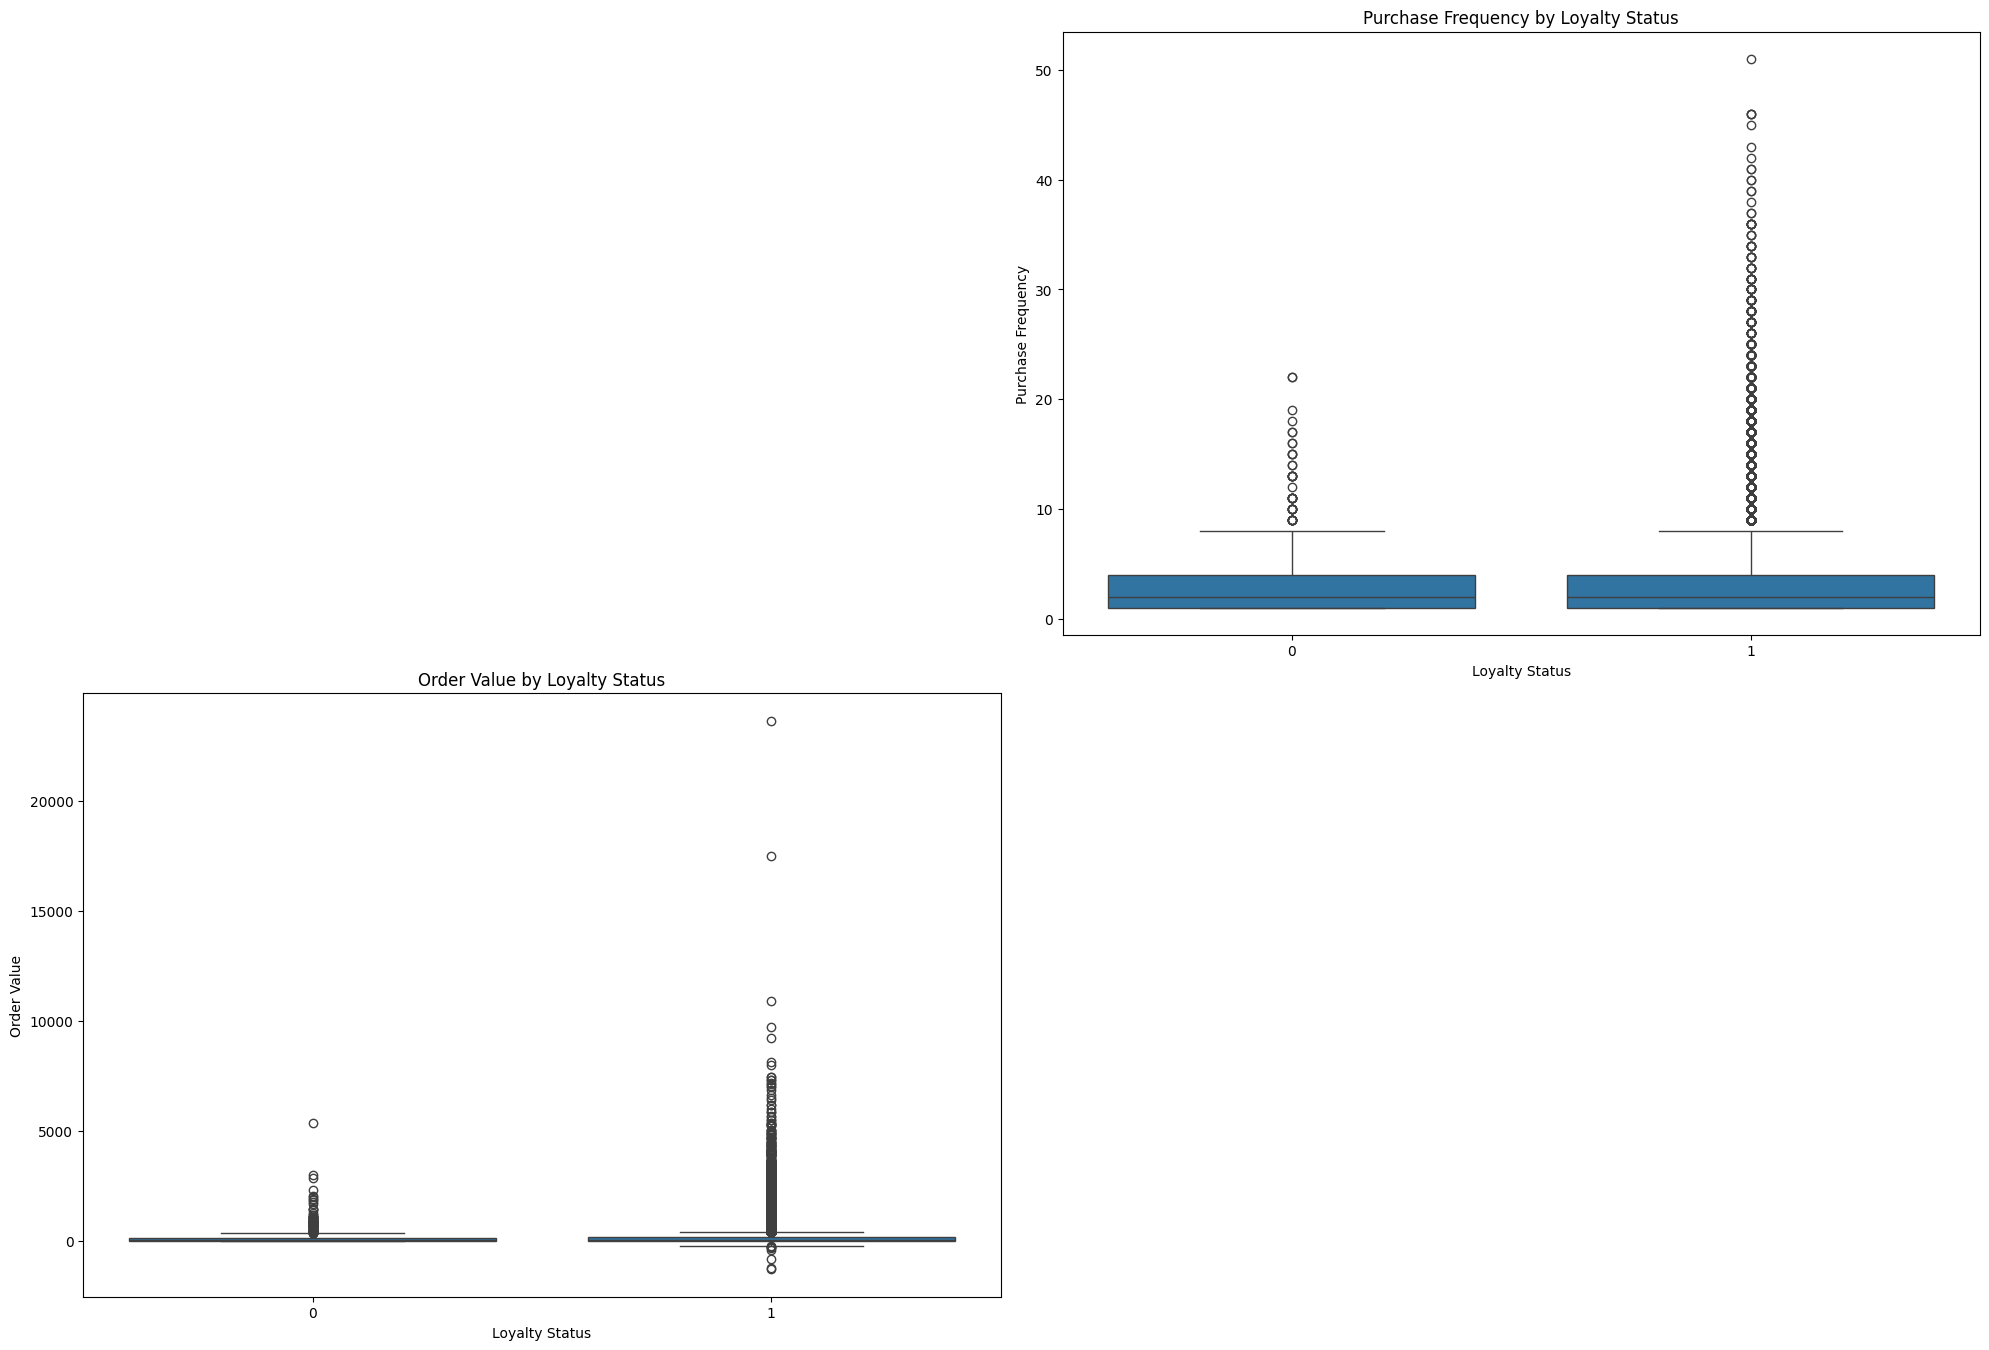

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# Assuming merged_data is your DataFrame
# merged_data = pd.read_csv('your_data.csv')  # Load your data if not already loaded

def seasonal_purchasing_trends(merged_data: pd.DataFrame) -> None:
    """Visualize sales trends over time by product category."""
    try:
        merged_data['purchase_datetime'] = pd.to_datetime(merged_data['purchase_datetime'])
        merged_data['month'] = merged_data['purchase_datetime'].dt.to_period('M')
        
        sales_trends = merged_data.groupby(['month', 'product_category'])['gross_price'].sum().reset_index()
        
        plt.subplot(3, 2, 1)
        sns.lineplot(data=sales_trends, x='month', y='gross_price', hue='product_category')
        plt.title('Sales Trends Over Time by Product Category')
        plt.xlabel('Month')
        plt.ylabel('Sales Amount')
        plt.xticks(rotation=45)
    except KeyError as e:
        print(f"KeyError in seasonal_purchasing_trends: {e}")

def review_sentiment_impact_on_sales(merged_data: pd.DataFrame) -> None:
    """Visualize sentiment score vs. sales volume."""
    try:
        sales_sentiment = merged_data.groupby('product_id').agg({
            'sentiment_score': 'mean',
            'gross_price': 'sum'
        }).reset_index()
        
        plt.subplot(3, 2, 2)
        sns.scatterplot(data=sales_sentiment, x='sentiment_score', y='gross_price')
        plt.title('Sentiment Score vs. Sales Volume')
        plt.xlabel('Sentiment Score')
        plt.ylabel('Sales Volume')
    except KeyError as e:
        print(f"KeyError in review_sentiment_impact_on_sales: {e}")

def customer_segmentation(merged_data: pd.DataFrame) -> None:
    """Visualize customer segmentation based on purchasing behavior."""
    try:
        customer_data = merged_data.groupby('customer_id').agg({
            'order_id': 'nunique',
            'gross_price': 'mean',
            'product_category': lambda x: x.mode()[0]
        }).reset_index()
        
        customer_data.columns = ['customer_id', 'purchase_frequency', 'avg_order_value', 'favorite_category']
        
        kmeans = KMeans(n_clusters=3)
        customer_data['cluster'] = kmeans.fit_predict(customer_data[['purchase_frequency', 'avg_order_value']])
        
        ax = plt.subplot(3, 2, 3, projection='3d')
        scatter = ax.scatter(customer_data['purchase_frequency'], customer_data['avg_order_value'], customer_data['cluster'], c=customer_data['cluster'], cmap='viridis')
        ax.set_title('Customer Segmentation Based on Purchasing Behavior')
        ax.set_xlabel('Purchase Frequency')
        ax.set_ylabel('Average Order Value')
        ax.set_zlabel('Cluster')
        plt.legend(*scatter.legend_elements(), title="Clusters")
    except KeyError as e:
        print(f"KeyError in customer_segmentation: {e}")

def loyalty_program_impact(merged_data: pd.DataFrame) -> None:
    """Visualize impact of loyalty programs on customer behavior."""
    try:
        loyalty_data = merged_data.groupby(['customer_id', 'loyatlty_status']).agg({
            'order_id': 'nunique',
            'gross_price': 'sum'
        }).reset_index()
        
        plt.subplot(3, 2, 4)
        sns.boxplot(data=loyalty_data, x='loyatlty_status', y='order_id')
        plt.title('Purchase Frequency by Loyalty Status')
        plt.xlabel('Loyalty Status')
        plt.ylabel('Purchase Frequency')
        
        plt.subplot(3, 2, 5)
        sns.boxplot(data=loyalty_data, x='loyatlty_status', y='gross_price')
        plt.title('Order Value by Loyalty Status')
        plt.xlabel('Loyalty Status')
        plt.ylabel('Order Value')
    except KeyError as e:
        print(f"KeyError in loyalty_program_impact: {e}")

def product_category_performance(merged_data: pd.DataFrame) -> None:
    """Visualize product category performance over time."""
    try:
        merged_data['purchase_datetime'] = pd.to_datetime(merged_data['purchase_datetime'])
        merged_data['month'] = merged_data['purchase_datetime'].dt.to_period('M')
        
        category_performance = merged_data.groupby(['month', 'product_category'])['gross_price'].sum().unstack().fillna(0)
        
        plt.subplot(3, 2, 6)
        category_performance.plot(kind='area', stacked=True, figsize=(14, 10), colormap='viridis', ax=plt.gca())
        plt.title('Product Category Performance Over Time')
        plt.xlabel('Month')
        plt.ylabel('Sales Amount')
        plt.xticks(rotation=45)
        plt.legend(title='Product Category')
    except KeyError as e:
        print(f"KeyError in product_category_performance: {e}")

plt.figure(figsize=(20, 20))
seasonal_purchasing_trends(merged_data)
review_sentiment_impact_on_sales(merged_data)
customer_segmentation(merged_data)
loyalty_program_impact(merged_data)
product_category_performance(merged_data)
plt.tight_layout()
plt.show()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


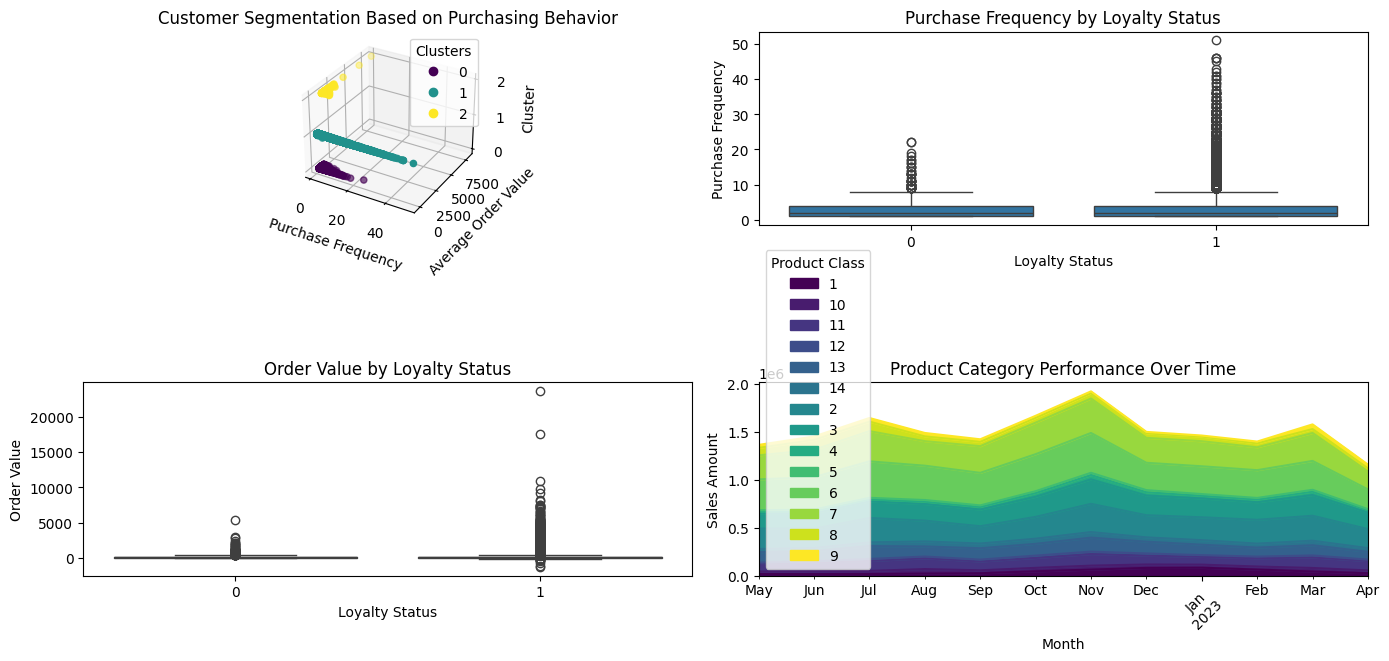

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# Assuming merged_data is your DataFrame
# merged_data = pd.read_csv('your_data.csv')  # Load your data if not already loaded

def seasonal_purchasing_trends(merged_data: pd.DataFrame) -> None:
    """Visualize sales trends over time by product class."""
    try:
        merged_data['purchase_datetime'] = pd.to_datetime(merged_data['purchase_datetime'])
        merged_data['month'] = merged_data['purchase_datetime'].dt.to_period('M')
        
        # Ensure gross_price is numeric
        merged_data['gross_price'] = pd.to_numeric(merged_data['gross_price'], errors='coerce')
        
        sales_trends = merged_data.groupby(['month', 'product_class'])['gross_price'].sum().reset_index()
        
        plt.subplot(3, 2, 1)
        sns.lineplot(data=sales_trends, x='month', y='gross_price', hue='product_class')
        plt.title('Sales Trends Over Time by Product Class')
        plt.xlabel('Month')
        plt.ylabel('Sales Amount')
        plt.xticks(rotation=45)
    except KeyError as e:
        print(f"KeyError in seasonal_purchasing_trends: {e}")
    except TypeError as e:
        print(f"TypeError in seasonal_purchasing_trends: {e}")

def customer_segmentation(merged_data: pd.DataFrame) -> None:
    """Visualize customer segmentation based on purchasing behavior."""
    try:
        customer_data = merged_data.groupby('customer_id').agg({
            'order_id': 'nunique',
            'gross_price': 'mean',
            'product_class': lambda x: x.mode()[0]
        }).reset_index()
        
        customer_data.columns = ['customer_id', 'purchase_frequency', 'avg_order_value', 'favorite_class']
        
        kmeans = KMeans(n_clusters=3)
        customer_data['cluster'] = kmeans.fit_predict(customer_data[['purchase_frequency', 'avg_order_value']])
        
        ax = plt.subplot(3, 2, 3, projection='3d')
        scatter = ax.scatter(customer_data['purchase_frequency'], customer_data['avg_order_value'], customer_data['cluster'], c=customer_data['cluster'], cmap='viridis')
        ax.set_title('Customer Segmentation Based on Purchasing Behavior')
        ax.set_xlabel('Purchase Frequency')
        ax.set_ylabel('Average Order Value')
        ax.set_zlabel('Cluster')
        plt.legend(*scatter.legend_elements(), title="Clusters")
    except KeyError as e:
        print(f"KeyError in customer_segmentation: {e}")

def loyalty_program_impact(merged_data: pd.DataFrame) -> None:
    """Visualize impact of loyalty programs on customer behavior."""
    try:
        loyalty_data = merged_data.groupby(['customer_id', 'loyatlty_status']).agg({
            'order_id': 'nunique',
            'gross_price': 'sum'
        }).reset_index()
        
        plt.subplot(3, 2, 4)
        sns.boxplot(data=loyalty_data, x='loyatlty_status', y='order_id')
        plt.title('Purchase Frequency by Loyalty Status')
        plt.xlabel('Loyalty Status')
        plt.ylabel('Purchase Frequency')
        
        plt.subplot(3, 2, 5)
        sns.boxplot(data=loyalty_data, x='loyatlty_status', y='gross_price')
        plt.title('Order Value by Loyalty Status')
        plt.xlabel('Loyalty Status')
        plt.ylabel('Order Value')
    except KeyError as e:
        print(f"KeyError in loyalty_program_impact: {e}")

def product_category_performance(merged_data: pd.DataFrame) -> None:
    """Visualize product category performance over time."""
    try:
        merged_data['purchase_datetime'] = pd.to_datetime(merged_data['purchase_datetime'])
        merged_data['month'] = merged_data['purchase_datetime'].dt.to_period('M')
        
        # Ensure gross_price is numeric
        merged_data['gross_price'] = pd.to_numeric(merged_data['gross_price'], errors='coerce')
        
        category_performance = merged_data.groupby(['month', 'product_class'])['gross_price'].sum().unstack().fillna(0)
        
        plt.subplot(3, 2, 6)
        category_performance.plot(kind='area', stacked=True, figsize=(14, 10), colormap='viridis', ax=plt.gca())
        plt.title('Product Category Performance Over Time')
        plt.xlabel('Month')
        plt.ylabel('Sales Amount')
        plt.xticks(rotation=45)
        plt.legend(title='Product Class')
    except KeyError as e:
        print(f"KeyError in product_category_performance: {e}")
    except TypeError as e:
        print(f"TypeError in product_category_performance: {e}")

plt.figure(figsize=(20, 20))
# seasonal_purchasing_trends(merged_data)
customer_segmentation(merged_data)
loyalty_program_impact(merged_data)
product_category_performance(merged_data)
plt.tight_layout()
plt.show()

In [58]:
merged_data.columns

Index(['order_id', 'customer_id', 'store_id', 'product_id', 'direction',
       'gross_price', 'price_reduction', 'purchase_datetime', 'product_class',
       'address_id', 'birthdate', 'gender', 'job_type', 'email_provider',
       'flag_phone_provided', 'flag_privacy', 'postal_code', 'district',
       'region', 'account_id', 'favorite_store', 'loyalty_type',
       'loyatlty_status', 'activation_date', 'month'],
      dtype='object')